In [ ]:
# Small-data turn-on/off for all 6 notebook runs (01→06). Set once; applies to full pipeline.
USE_SMALL_DATA = False  # True = small data (N_SAMPLES); False = full data
N_SAMPLES = 10       # Max observations when USE_SMALL_DATA (e.g. 10 for quick test)
N_EPOCHS = 1       # Max training epochs when USE_SMALL_DATA (02, 03, 04)
# 01: applied automatically below. 02-04: epochs/n_epochs/num_epochs set automatically.

In [ ]:
# Imports and setup (needed when 02-06 run in separate kernel)
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Repo root for src imports
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass
def _find_repo_root():
    cwd = Path.cwd().resolve()
    for p in [Path('/content/drive/MyDrive/multihead-attention-robustness'),
              Path('/content/drive/My Drive/multihead-attention-robustness'),
              Path('/content/repo_run')]:
        if (p / 'src').exists():
            return p
    drive_root = Path('/content/drive')
    if drive_root.exists():
        for base in [drive_root / 'MyDrive', drive_root / 'My Drive', drive_root]:
            p = base / 'multihead-attention-robustness'
            if p.exists() and (p / 'src').exists():
                return p
    p = cwd
    for _ in range(10):
        if (p / 'src').exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return cwd.parent if cwd.name == 'notebooks' else cwd
repo_root = _find_repo_root()
sys.path.insert(0, str(repo_root))
from src.models.feature_token_transformer import FeatureTokenTransformer, SingleHeadTransformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
models = {}
training_history = {}
TRAINING_CONFIG = {
    'ols': {}, 'ridge': {'alpha': 1.0},
    'mlp': {'hidden_dims': [128, 64], 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'patience': 10},
    'transformer': {'d_model': 72, 'num_heads': 8, 'num_layers': 2, 'd_ff': 512, 'dropout': 0.1,
                   'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 100, 'patience': 20}
}


In [ ]:
# Load fresh data from master_table.csv (standalone: each notebook pulls its own data)
data_path = repo_root / 'data' / 'cross_sectional' / 'master_table.csv'
df = pd.read_csv(data_path)
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
class CrossSectionalDataSplitter:
    def __init__(self, train_start='2005-01-01', train_end='2017-12-31', val_start='2018-01-01', val_end='2019-12-31'):
        self.train_start, self.train_end = train_start, train_end
        self.val_start, self.val_end = val_start, val_end
    def split(self, master_table):
        master_table = master_table.copy()
        master_table.index = pd.to_datetime(master_table.index)
        return {'train': master_table.loc[self.train_start:self.train_end], 'val': master_table.loc[self.val_start:self.val_end]}
    def prepare_features_labels(self, data):
        if data.empty:
            return pd.DataFrame(), pd.Series()
        numeric_data = data.select_dtypes(include=[np.number])
        if numeric_data.empty:
            return pd.DataFrame(), pd.Series()
        exclude_cols = ['mktcap', 'market_cap', 'date', 'year', 'month', 'ticker', 'permno', 'gvkey']
        target_cols = ['return', 'returns', 'ret', 'target', 'y', 'next_return', 'forward_return', 'ret_1', 'ret_1m', 'ret_12m', 'future_return', 'returns_1d']
        target_col = None
        for tc in target_cols:
            for col in numeric_data.columns:
                if tc.lower() in col.lower() and col.lower() not in [ec.lower() for ec in exclude_cols]:
                    target_col = col
                    break
            if target_col:
                break
        if target_col is None:
            potential = [c for c in numeric_data.columns if c.lower() not in [ec.lower() for ec in exclude_cols]]
            target_col = potential[-2] if len(potential) > 1 else (potential[-1] if potential else numeric_data.columns[-1])
        feature_cols = [c for c in numeric_data.columns if c != target_col and c.lower() not in [ec.lower() for ec in exclude_cols]]
        if not feature_cols:
            feature_cols = [c for c in numeric_data.columns if c != target_col]
        if not feature_cols:
            feature_cols = numeric_data.columns[:-1].tolist()
            target_col = numeric_data.columns[-1]
        return numeric_data[feature_cols], numeric_data[target_col]
splitter = CrossSectionalDataSplitter()
data_splits = splitter.split(df)
train_df, val_df = data_splits['train'], data_splits['val']
X_train_df, y_train = splitter.prepare_features_labels(train_df)
X_val_df, y_val = splitter.prepare_features_labels(val_df)
X_train = X_train_df.fillna(0).values.astype(np.float32)
y_train = y_train.fillna(0).values.astype(np.float32)
X_val = X_val_df.fillna(0).values.astype(np.float32)
y_val = y_val.fillna(0).values.astype(np.float32)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
print(f'Loaded fresh data: train {X_train_scaled.shape[0]}, val {X_val_scaled.shape[0]}')


In [29]:
# Figure: Improvement/Degradation Matrix (Line Plot)
print("Generating Figure: Improvement/Degradation Matrix...")

if 'robustness_df' in locals() and len(robustness_df) > 0:
    training_epsilons = [0.25, 0.5, 1.0]
    df_plot = robustness_df[robustness_df['epsilon'].isin(training_epsilons)].copy()
    
    # Calculate improvements (adversarial - standard) for each attack and epsilon
    improvements = []
    attacks = ['A1', 'A2', 'A3', 'A4']
    
    for attack in attacks:
        for eps in training_epsilons:
            training_col = 'training_type' if 'training_type' in df_plot.columns else 'model_type'
            attack_col = 'attack' if 'attack' in df_plot.columns else 'attack_type'
            std_row = df_plot[(df_plot.get(training_col, pd.Series(['standard']*len(df_plot))) == 'standard') & 
                             (df_plot[attack_col].str.upper() == attack) &
                             (df_plot['model_name'] == 'Multi-Head Diversity') &
                             (df_plot['epsilon'] == eps)]
            adv_rows = df_plot[(df_plot.get(training_col, pd.Series(['adversarial']*len(df_plot))) == 'adversarial') & 
                              (df_plot[attack_col].str.upper() == attack) &
                              (df_plot['epsilon'] == eps)]
            
            if len(std_row) > 0 and len(adv_rows) > 0:
                std_rob = std_row['robustness'].iloc[0]
                best_adv_rob = adv_rows['robustness'].max()
                improvement = best_adv_rob - std_rob
                improvements.append({
                    'Attack': attack,
                    'Epsilon': eps,
                    'Improvement': improvement
                })
    
    if improvements:
        imp_df = pd.DataFrame(improvements)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot line for each attack
        for attack in attacks:
            attack_data = imp_df[imp_df['Attack'] == attack]
            if len(attack_data) > 0:
                epsilons = sorted(attack_data['Epsilon'].values)
                improvements = [attack_data[attack_data['Epsilon'] == eps]['Improvement'].iloc[0] 
                               for eps in epsilons]
                color = '#A23B72' if attack == 'A1' else '#2E86AB' if attack == 'A2' else '#F18F01' if attack == 'A3' else '#C73E1D'
                marker = 'o' if attack == 'A1' else 's' if attack == 'A2' else '^' if attack == 'A3' else 'D'
                ax.plot(epsilons, improvements, marker=marker, linewidth=2.5, markersize=10,
                       label=f'{attack}', color=color, markerfacecolor='white', markeredgewidth=2)
        
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
        ax.set_xlabel('Epsilon ($\\epsilon$)', fontsize=11, fontweight='bold')
        ax.set_ylabel('Improvement (Adversarial - Standard)', fontsize=11, fontweight='bold')
        ax.set_title('Adversarial Training Effectiveness: Improvement vs Degradation', 
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=10, framealpha=0.9, loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xticks(training_epsilons)
        
        # Add summary statistics
        avg_improvement = imp_df['Improvement'].mean()
        ax.text(0.02, 0.98, f'Average Improvement: {avg_improvement:.4f}', 
               transform=ax.transAxes, fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout()
        output_path = figures_dir / 'improvement_degradation_matrix_validation.pdf'
        plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.close()
        print(f" Saved: {output_path}")
    else:
        print(" No data for improvement matrix.")
else:
    print(" Robustness results not available.")

Generating Figure: Improvement/Degradation Matrix...


 Saved: /content/drive/MyDrive/multihead-attention-robustness/paper/figures/improvement_degradation_matrix_validation.pdf


#### 5.4.4. Save Time Series Plot 

The time series plot is already generated in section 4.2. This cell ensures it's saved to the figures directory.

In [30]:
# Ensure time series plot is saved (if it was generated in section 4.2)
print("Checking for time series plot...")

timeseries_path = figures_dir / 'timeseries_predictions_validation.pdf'
png_path = figures_dir / 'clean_vs_adversarial_ts.png'
if timeseries_path.exists():
    print(f" Time series plot already exists: {timeseries_path}")
    if png_path.exists():
        print(f" Paper figure exists: {png_path}")
    else:
        print(" Re-run section 4.2 (time series plot cell) to generate clean_vs_adversarial_ts.png for the paper.")
else:
    print("Time series plot not found. Run section 4.2 to generate it.")
    print("The plot will be automatically saved when generated.")

Checking for time series plot...
 Time series plot already exists: /content/drive/MyDrive/multihead-attention-robustness/paper/figures/timeseries_predictions_validation.pdf


### 5.5. Summary

All figures and tables have been generated and saved to:
- **Figures**: `paper/figures/`
- **Tables**: `paper/tables/`

These files are ready to be included in the LaTeX document.

In [31]:
# Summary
print("=" * 80)
print("GENERATION COMPLETE")
print("=" * 80)
print(f"\n Tables saved to: {tables_dir}")
print(f" Figures saved to: {figures_dir}")
print("\nGenerated files:")
print("\nTables:")
for table_file in sorted(tables_dir.glob('*.tex')):
    print(f"  ✓ {table_file.name}")

print("\nFigures:")
for fig_file in sorted(figures_dir.glob('*.pdf')):
    if fig_file.name.endswith('_validation.pdf') or fig_file.name in ['timeseries_predictions_validation.pdf', 
                                                                        'feature_importance_attention.pdf',
                                                                        'figure_i_a4_predictions.pdf']:
        print(f" {fig_file.name}")

print("\nAll files are ready for LaTeX compilation!")
print("\nNote: Some figures (feature_importance_attention.pdf, figure_i_a4_predictions.pdf)")
print("may need to be generated separately using the dedicated scripts.")

GENERATION COMPLETE

 Tables saved to: /content/drive/MyDrive/multihead-attention-robustness/paper/tables
 Figures saved to: /content/drive/MyDrive/multihead-attention-robustness/paper/figures

Generated files:

Tables:
  ✓ adversarial_effectiveness_summary.tex
  ✓ main_results.tex
  ✓ main_results_generated.tex
  ✓ robustness_extrapolation.tex
  ✓ robustness_training_epsilons.tex

Figures:
 feature_importance_attention.pdf
 improvement_degradation_matrix_validation.pdf
 robustness_heatmap_validation.pdf
 robustness_vs_epsilon_validation.pdf
 timeseries_predictions_validation.pdf

All files are ready for LaTeX compilation!

Note: Some figures (feature_importance_attention.pdf, figure_i_a4_predictions.pdf)
may need to be generated separately using the dedicated scripts.


GENERATING COMPREHENSIVE ROBUSTNESS VISUALIZATIONS


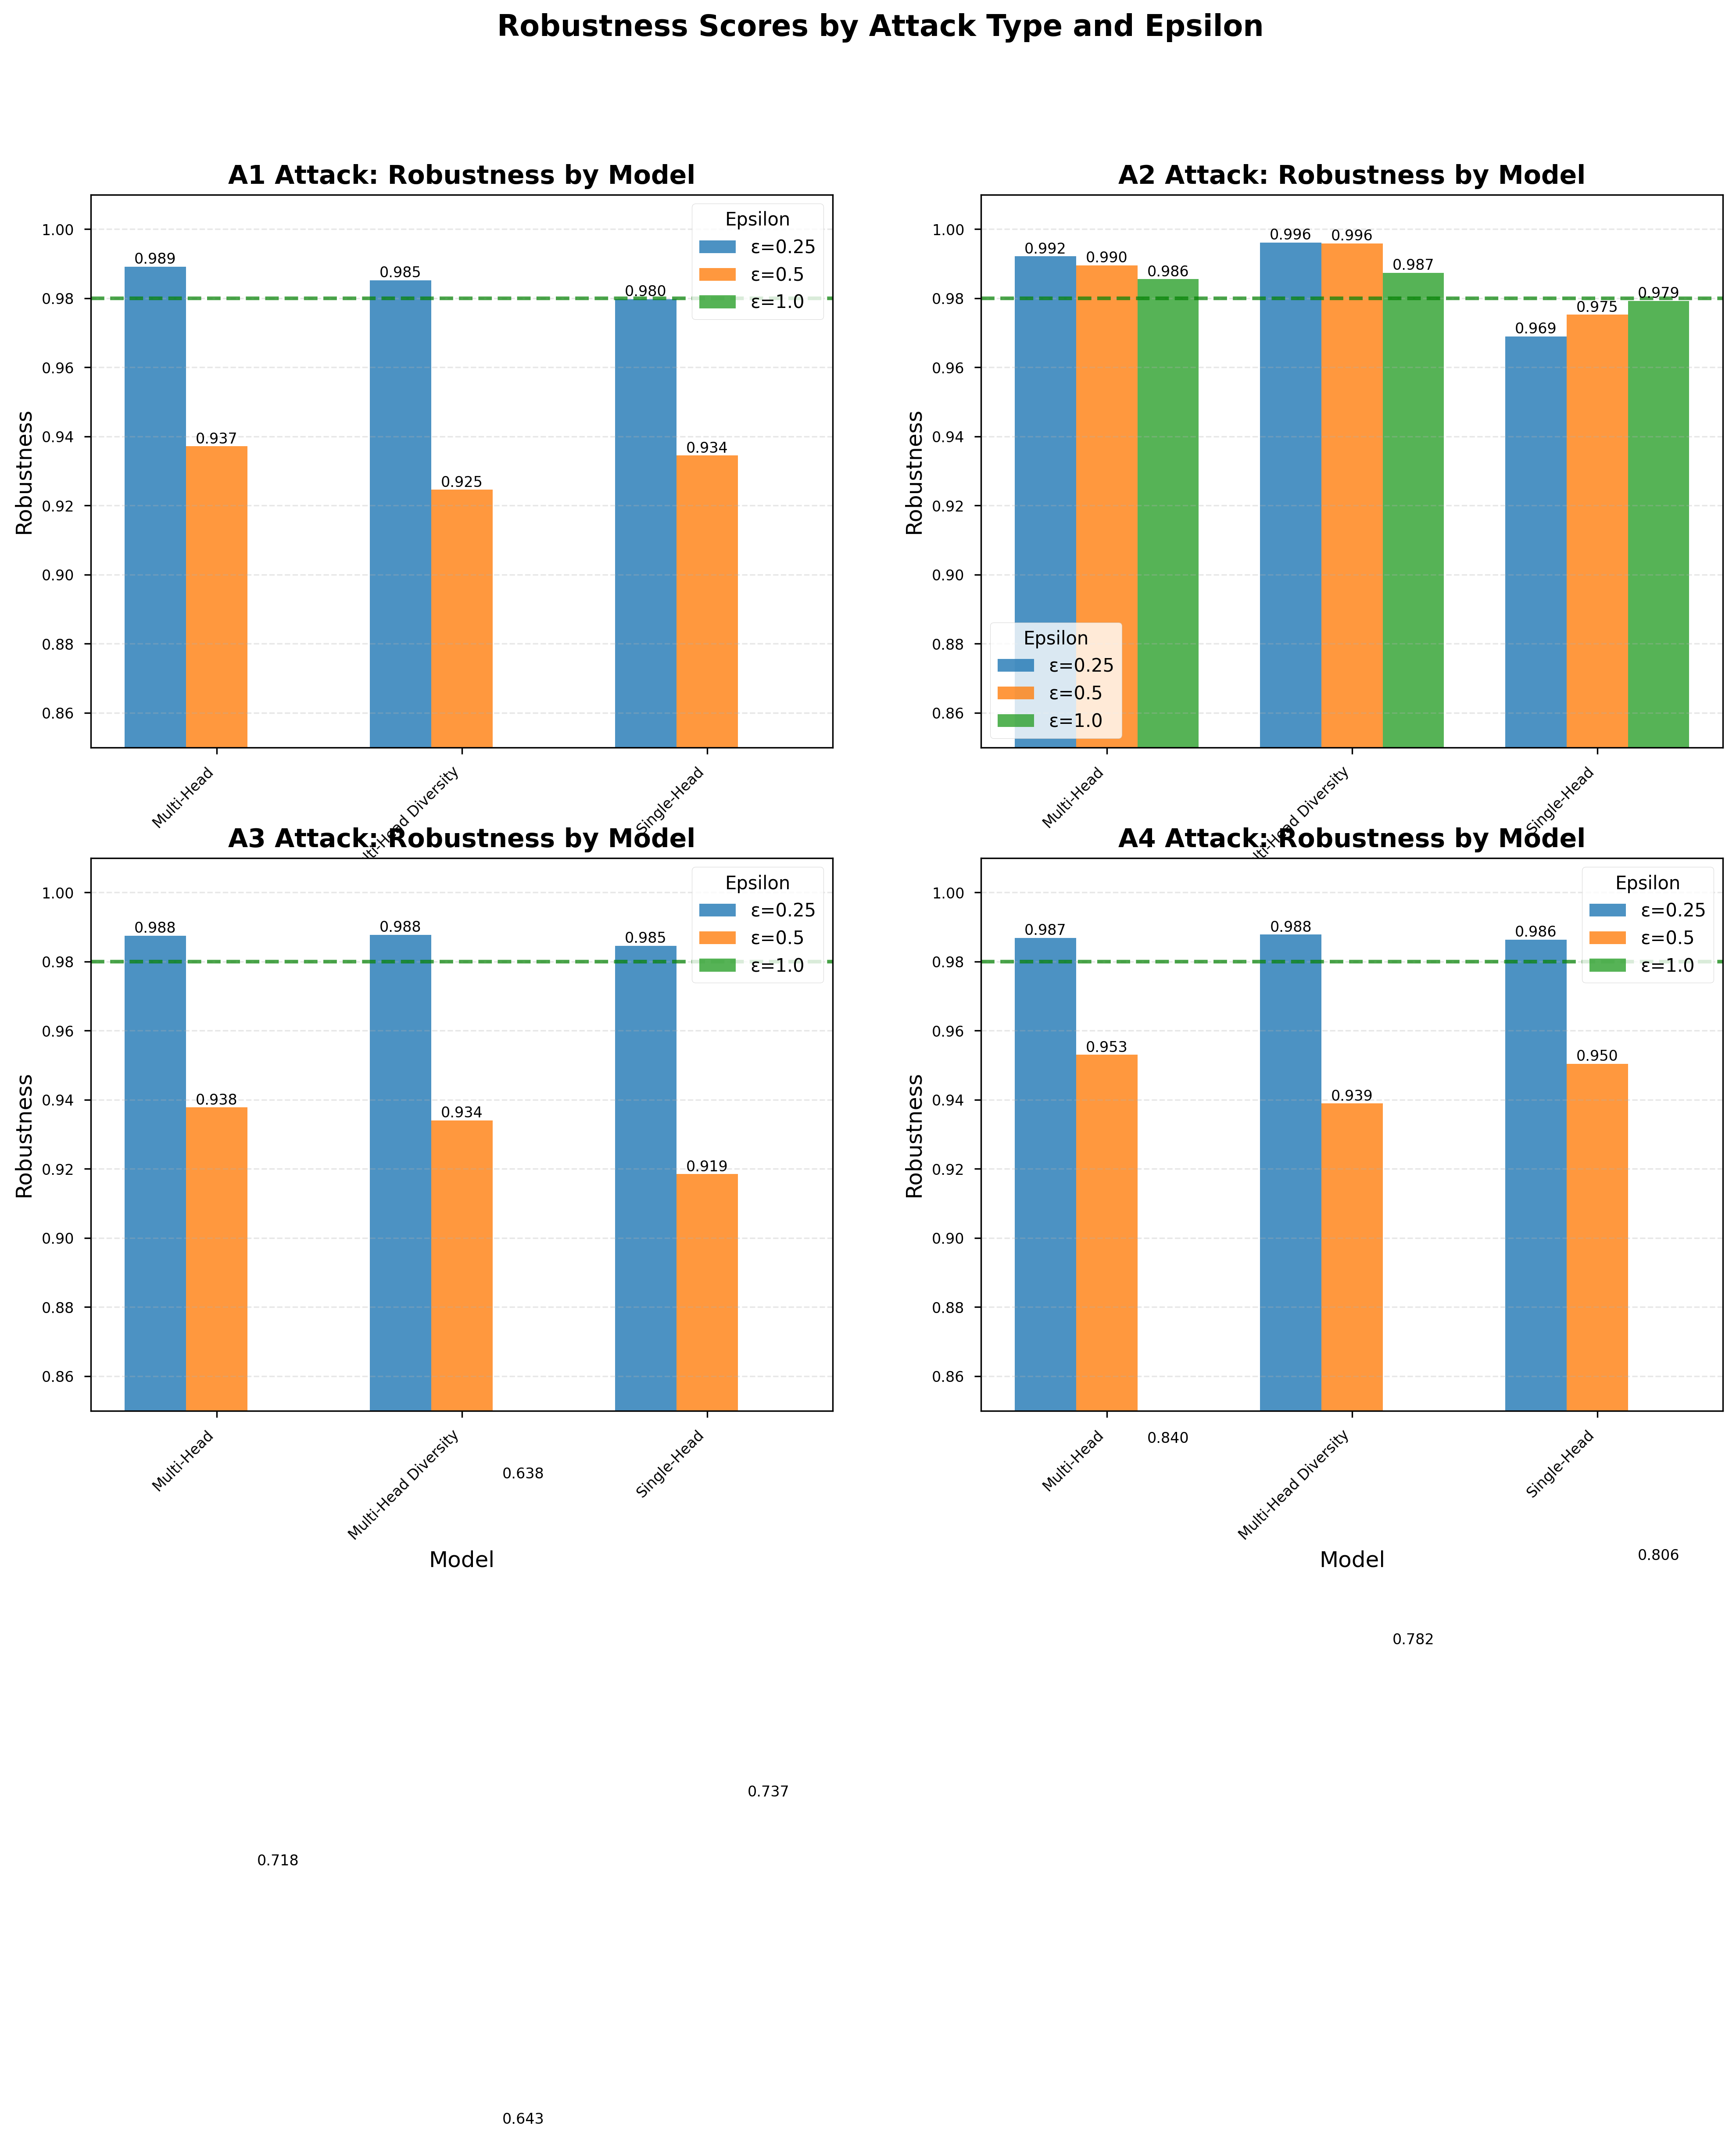

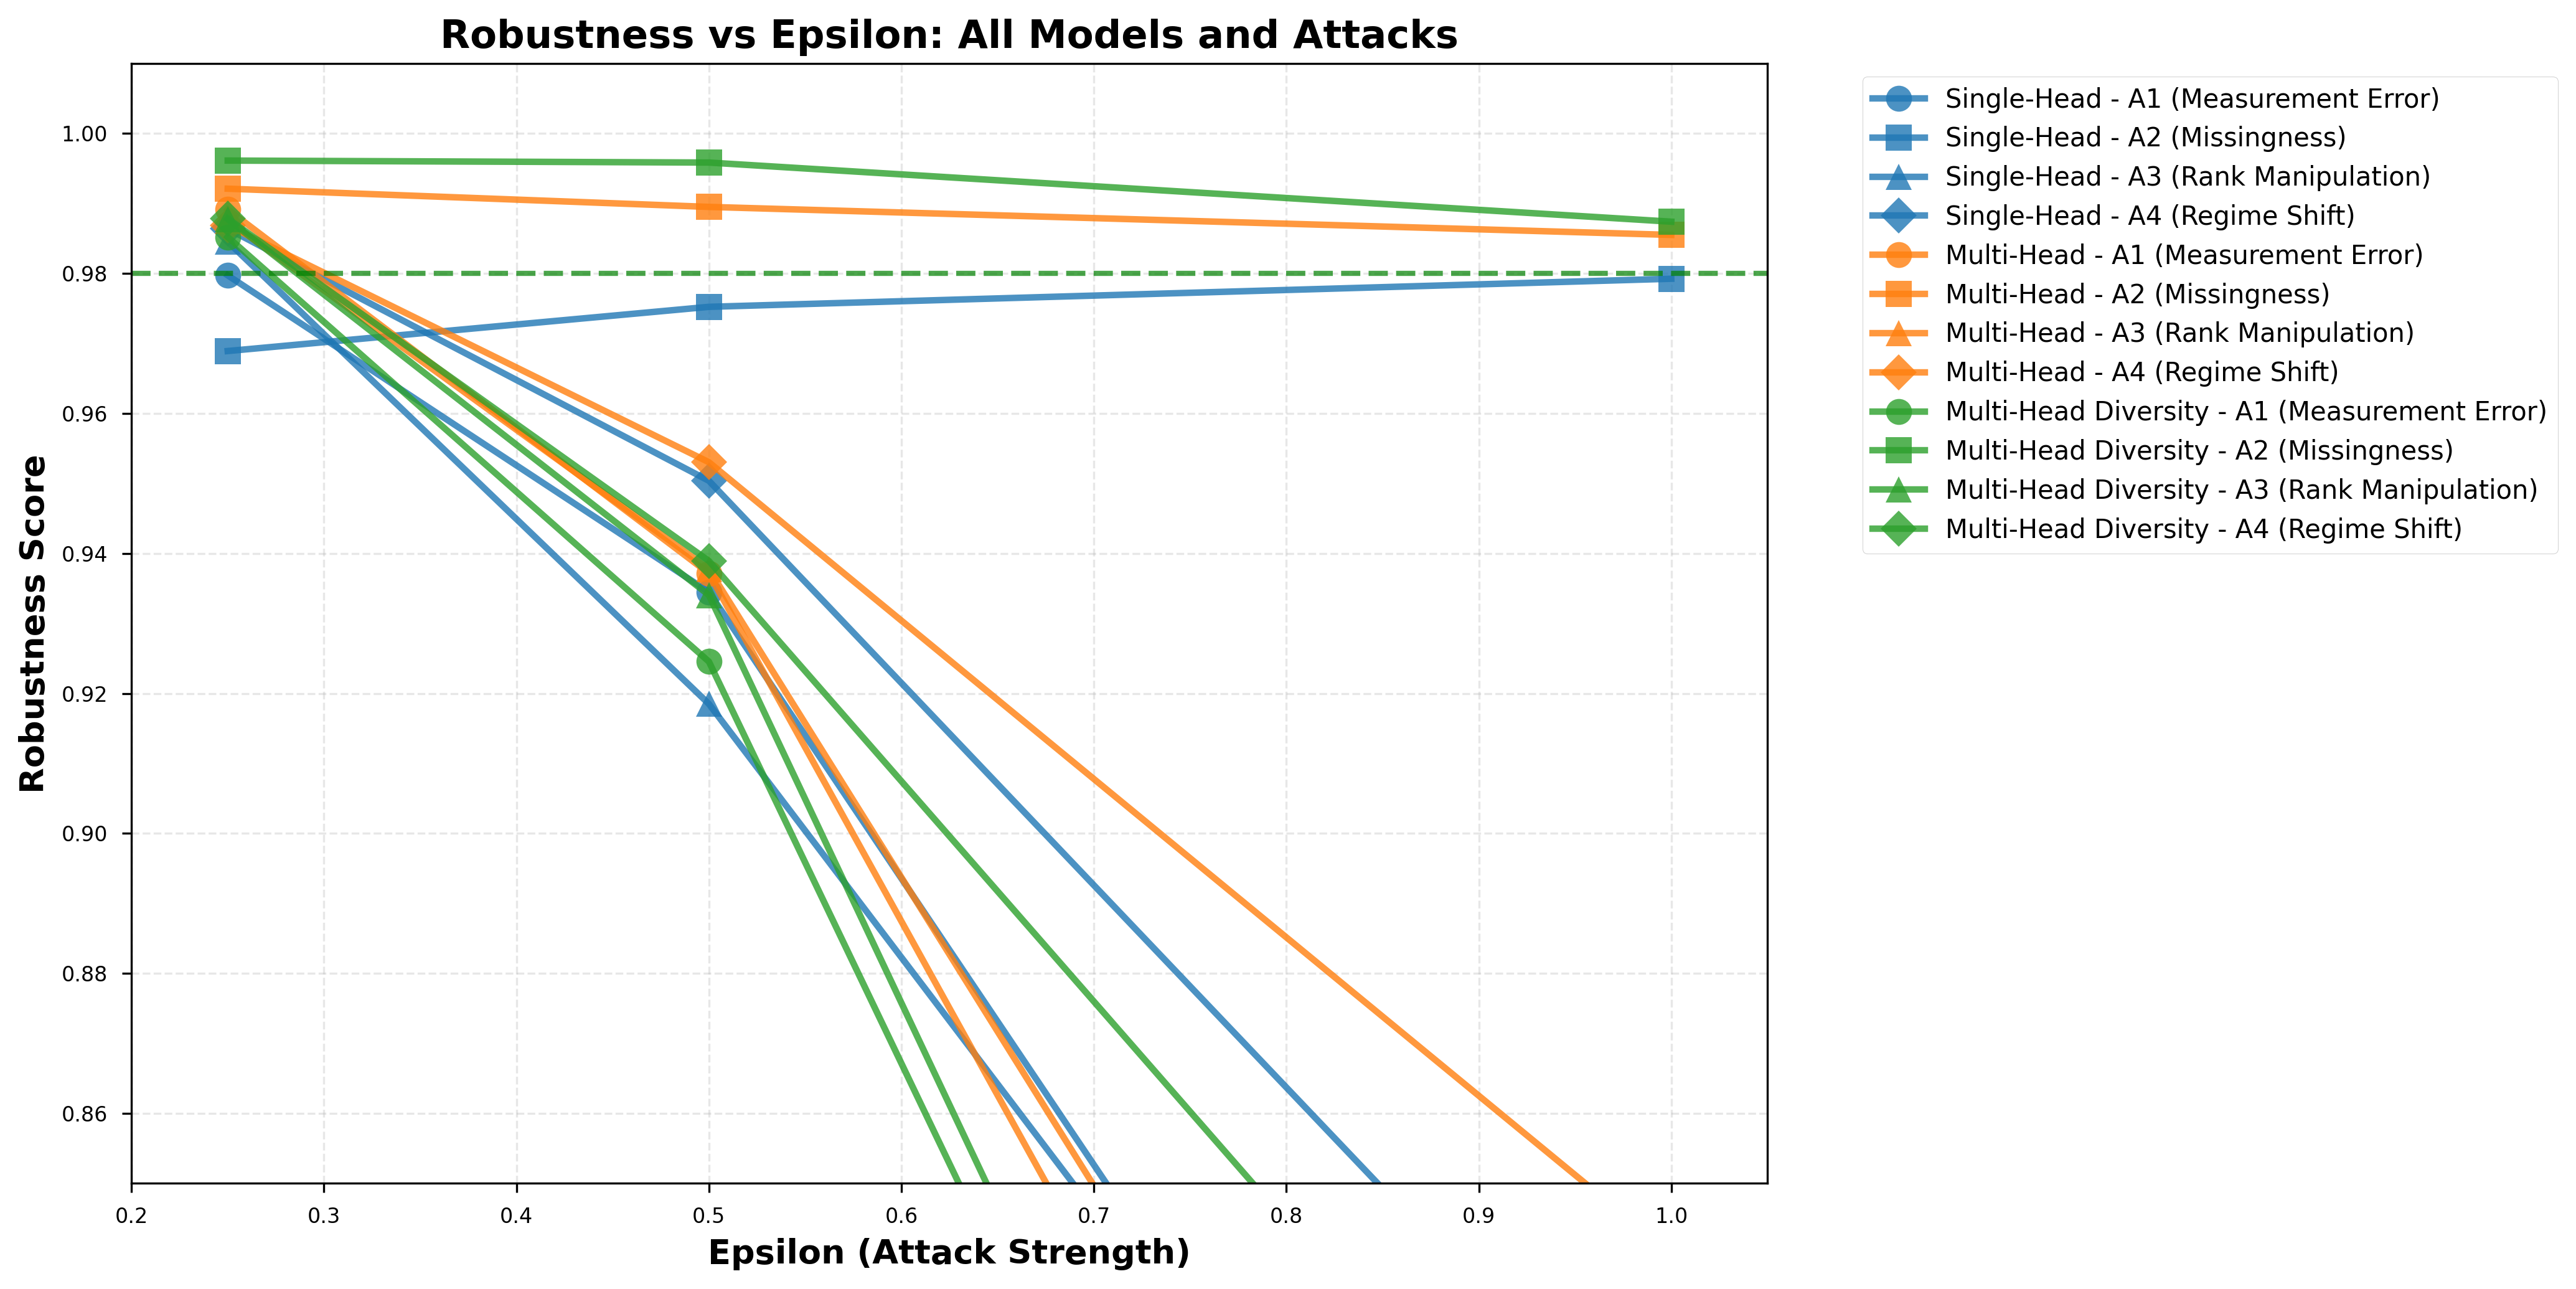

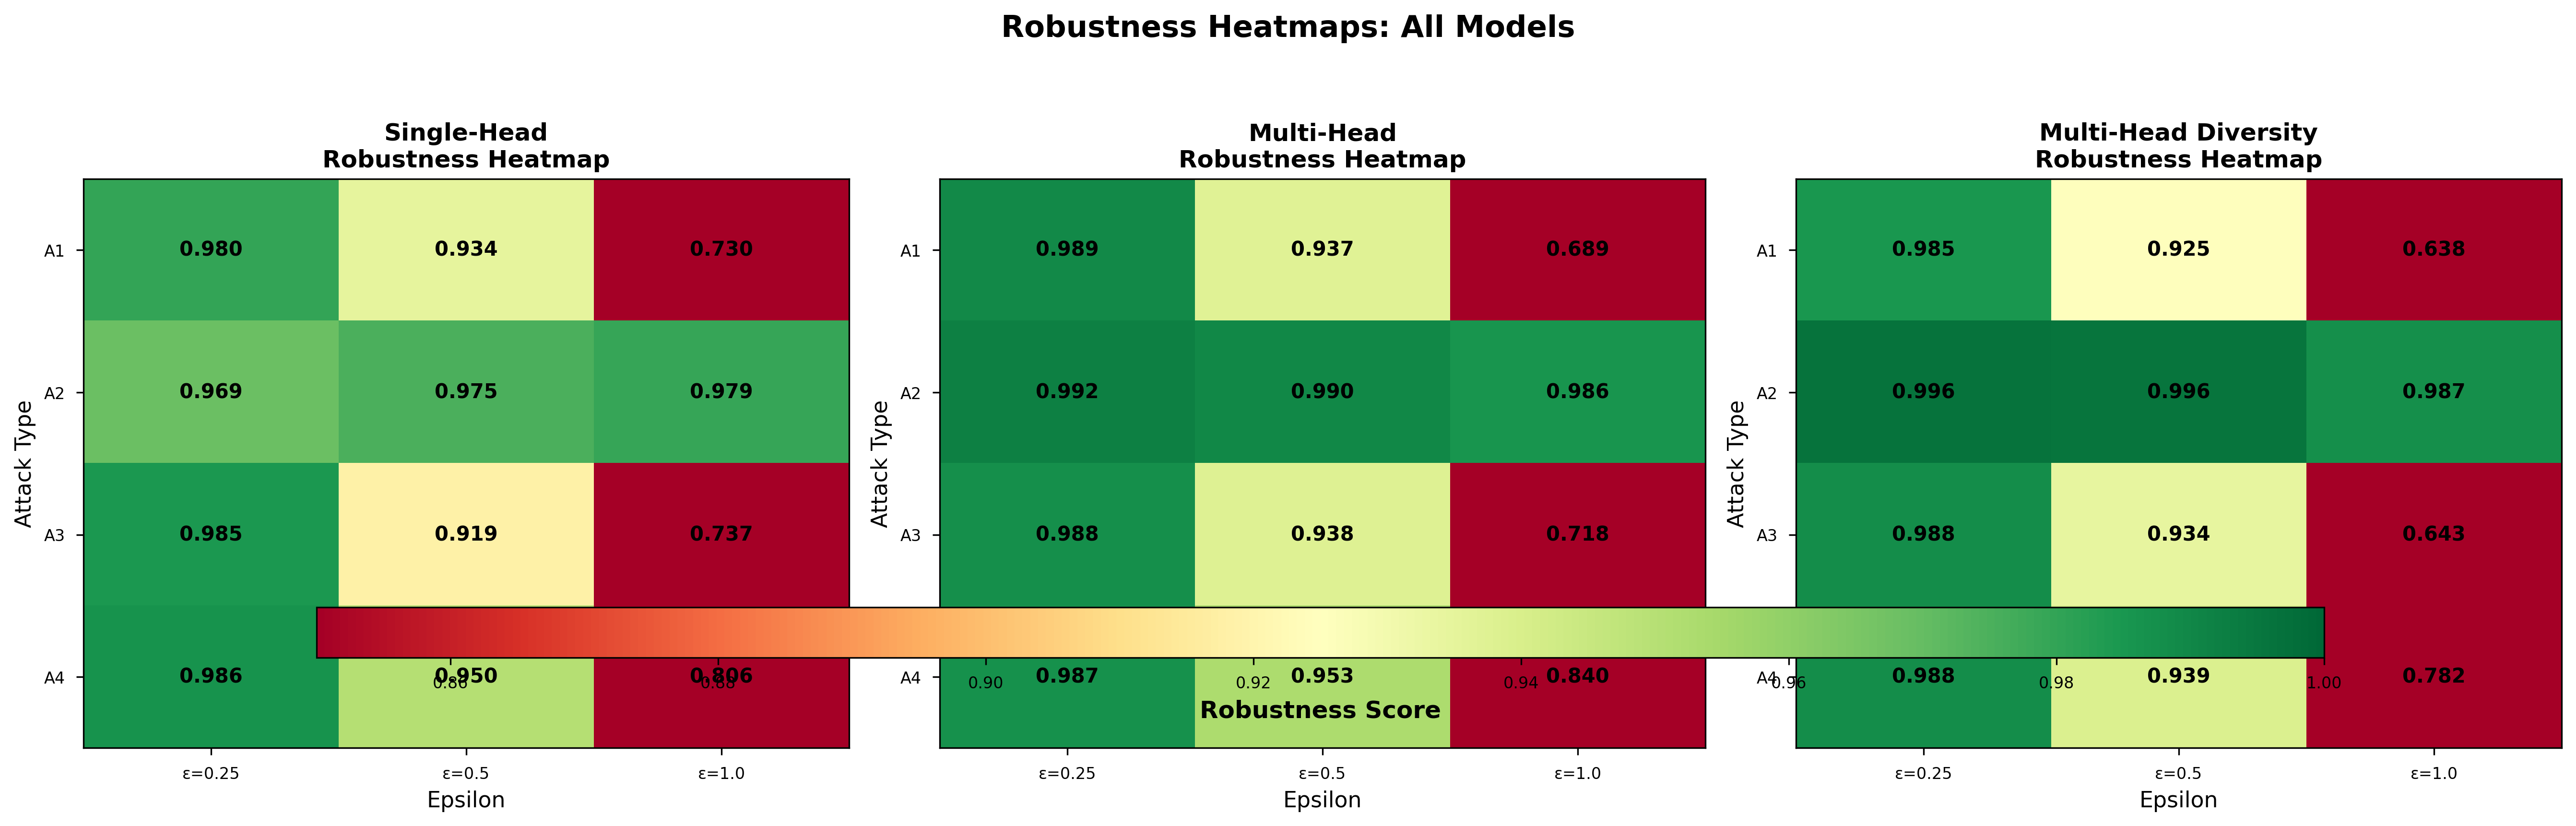

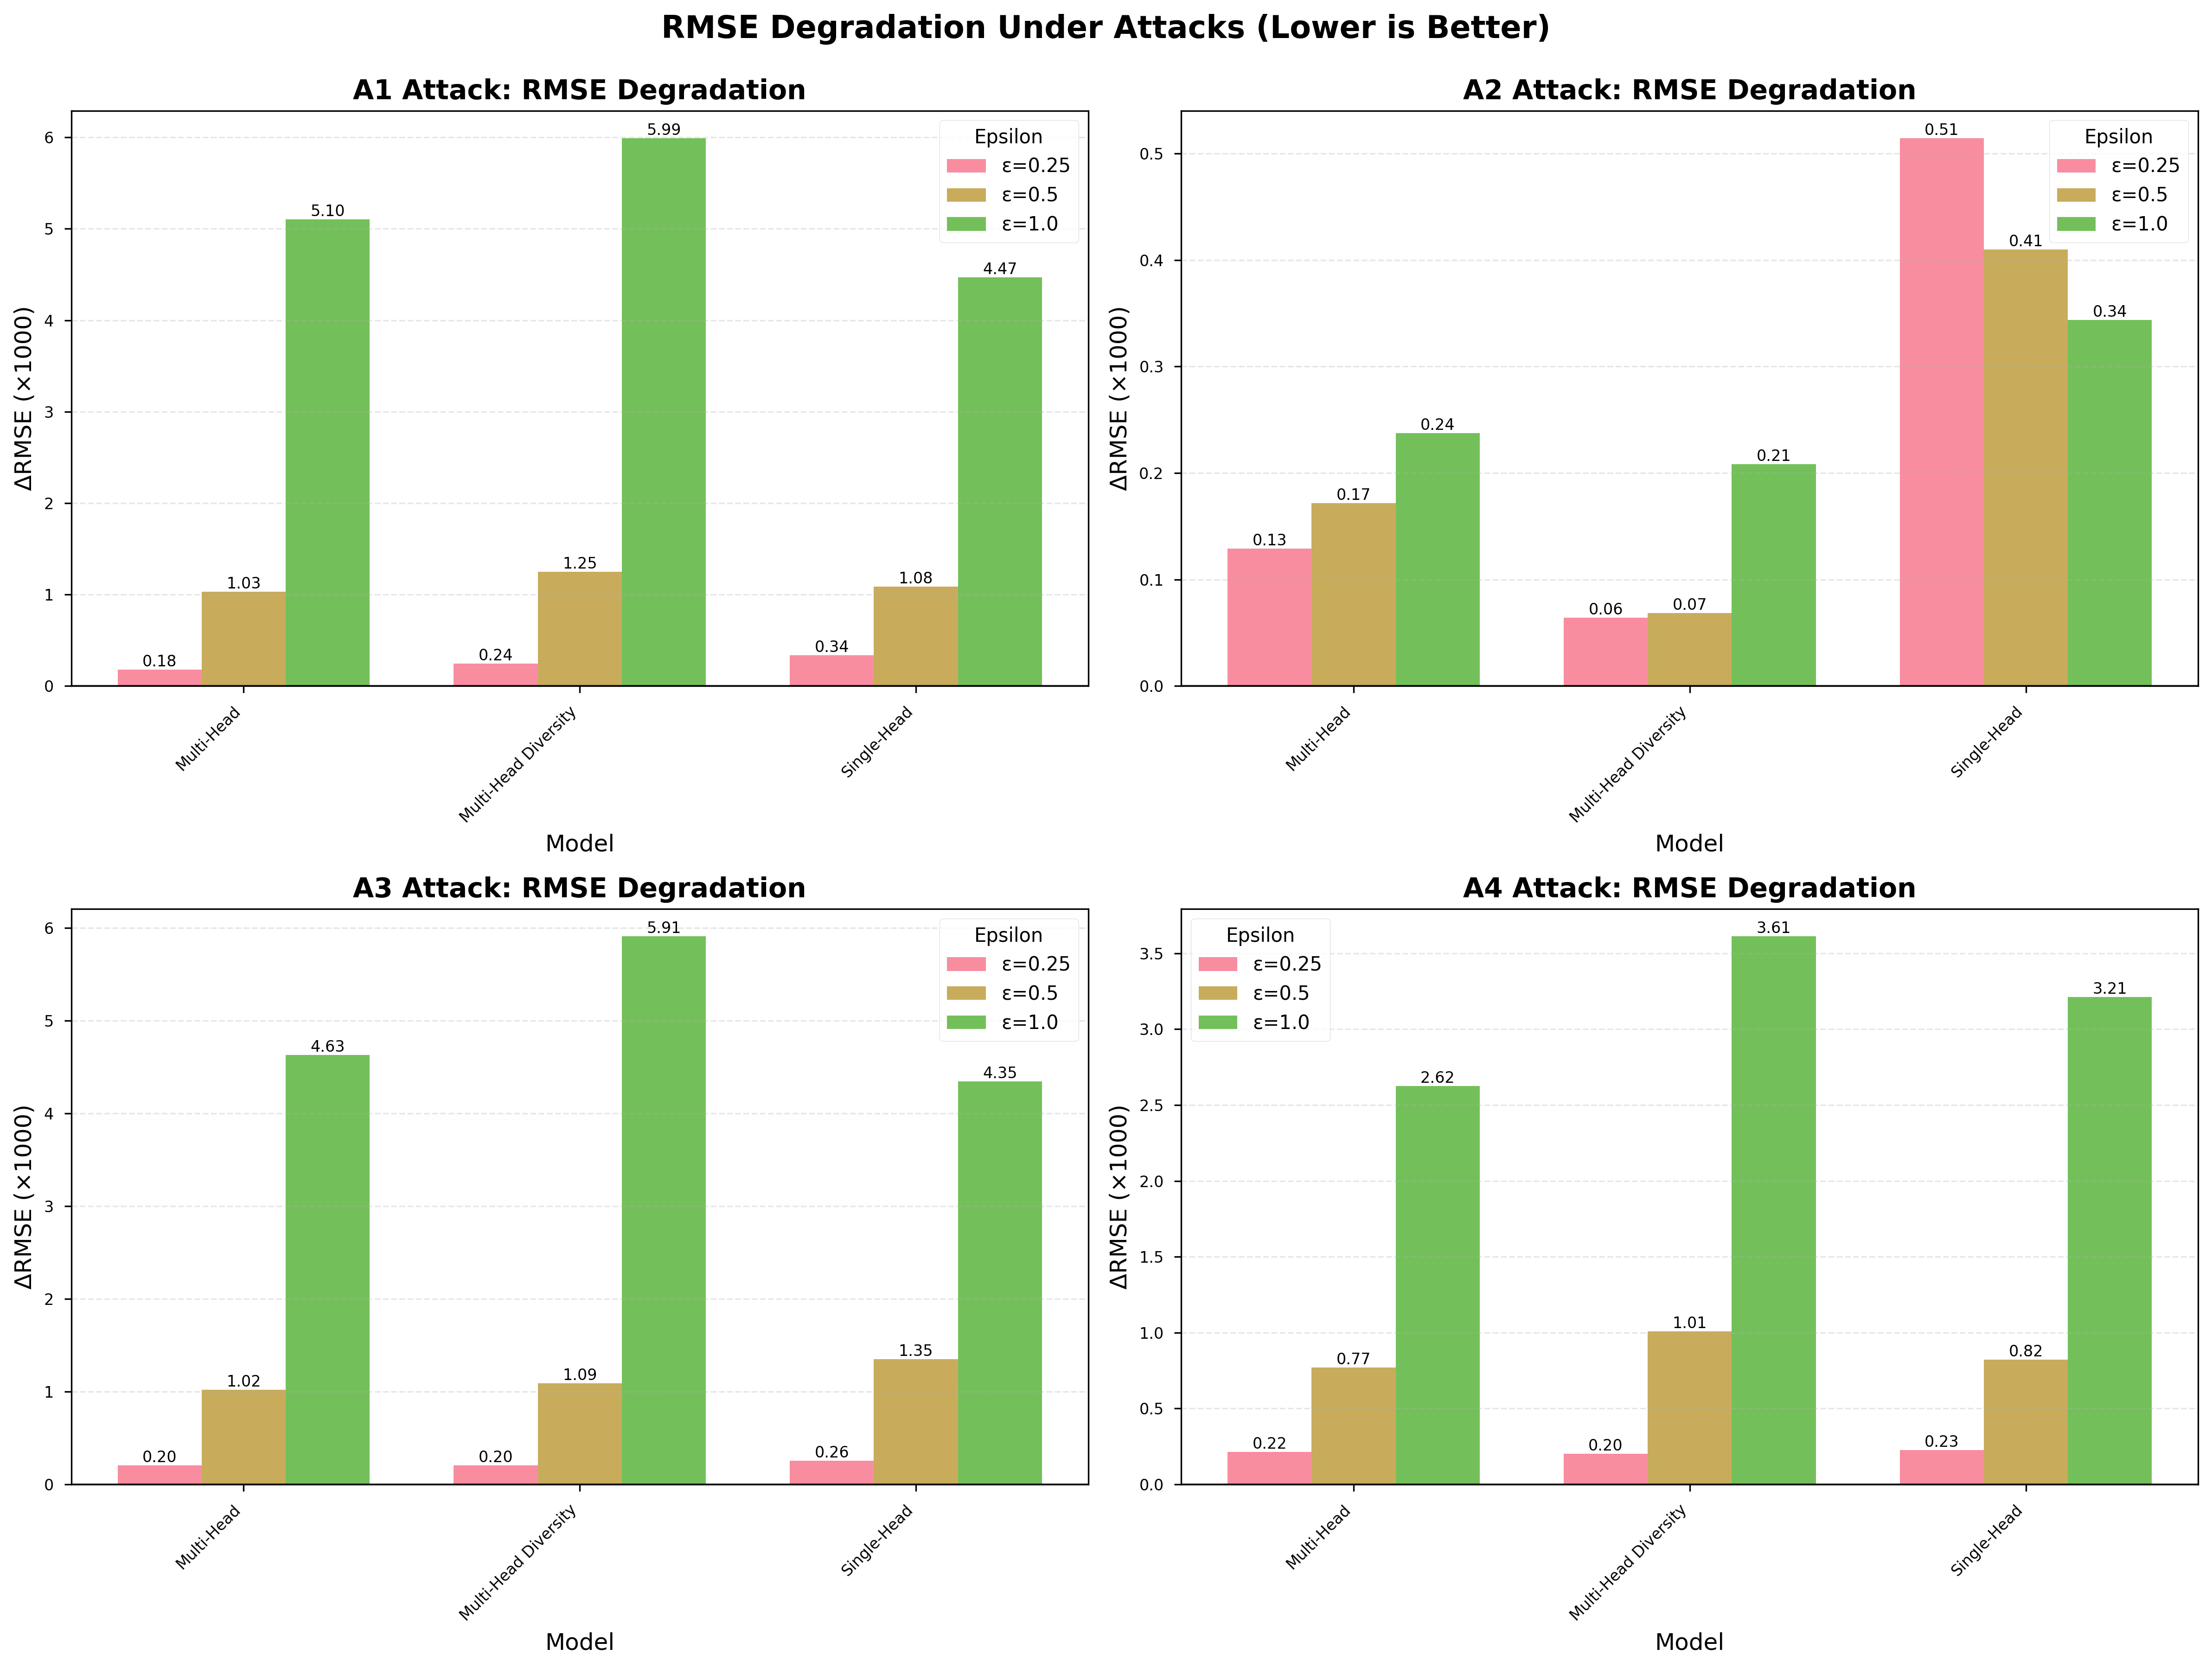

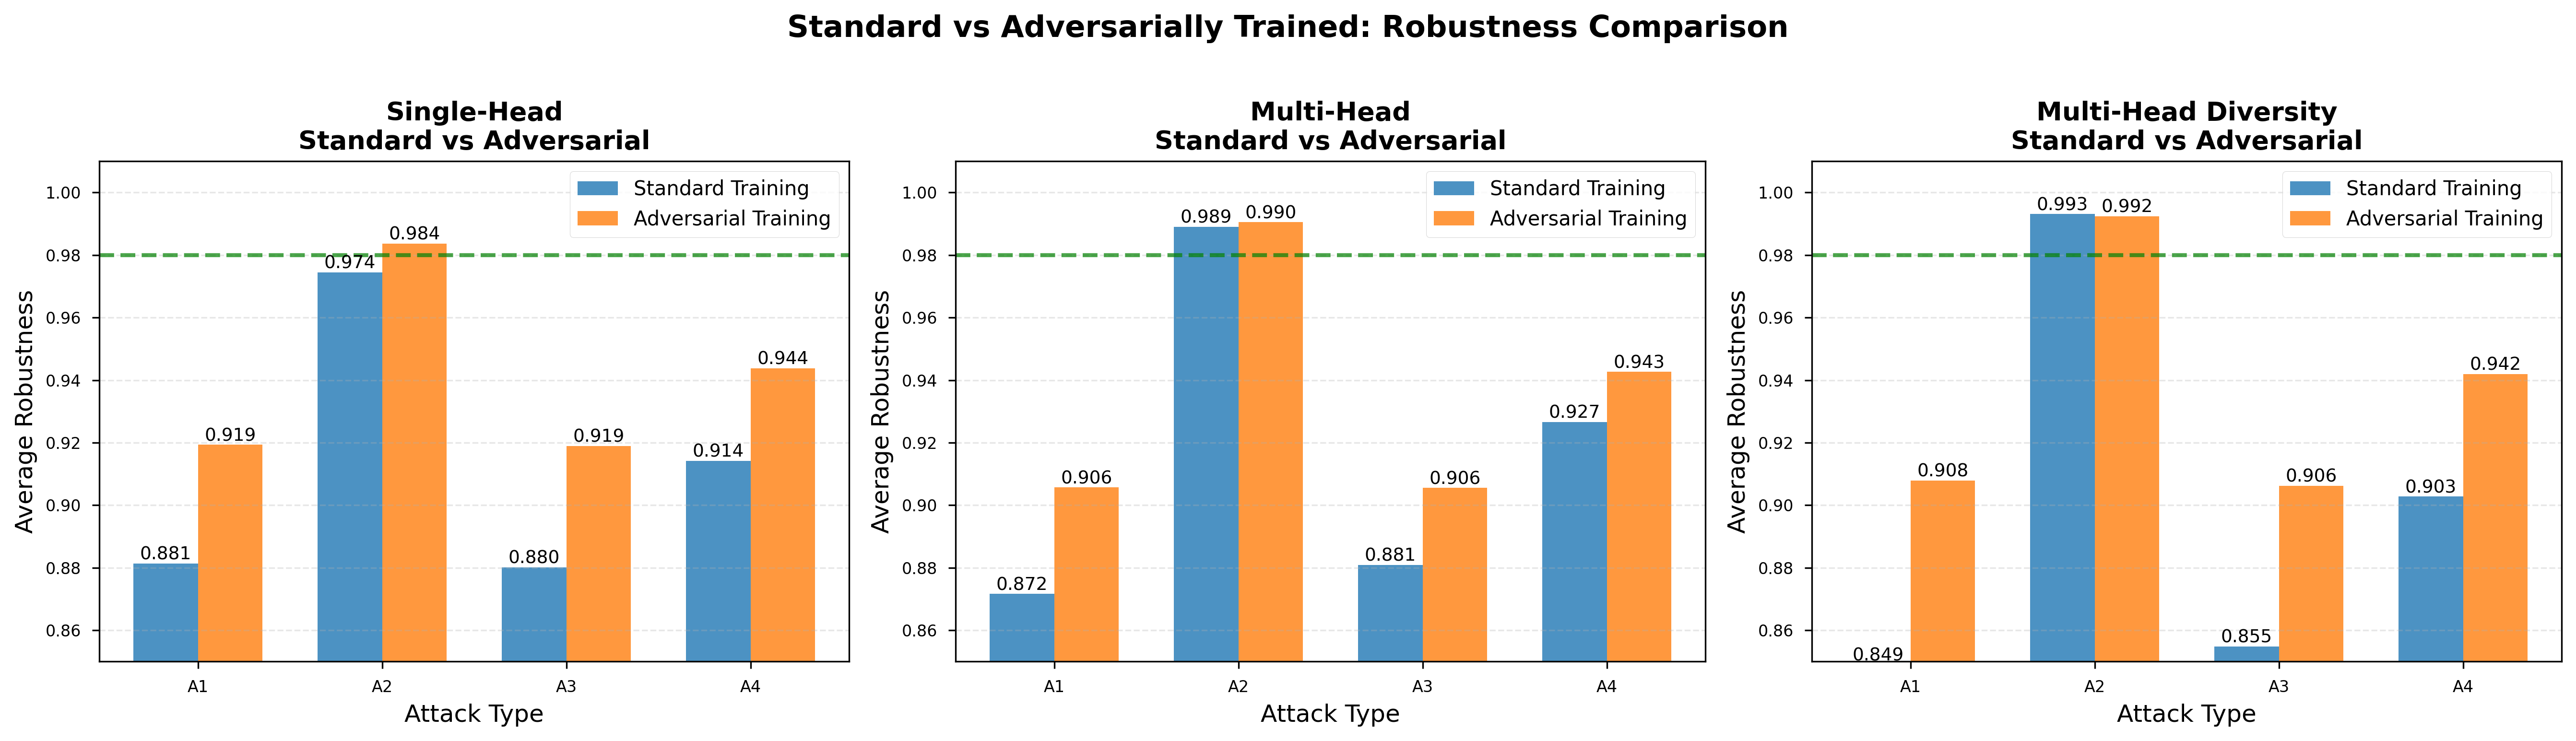

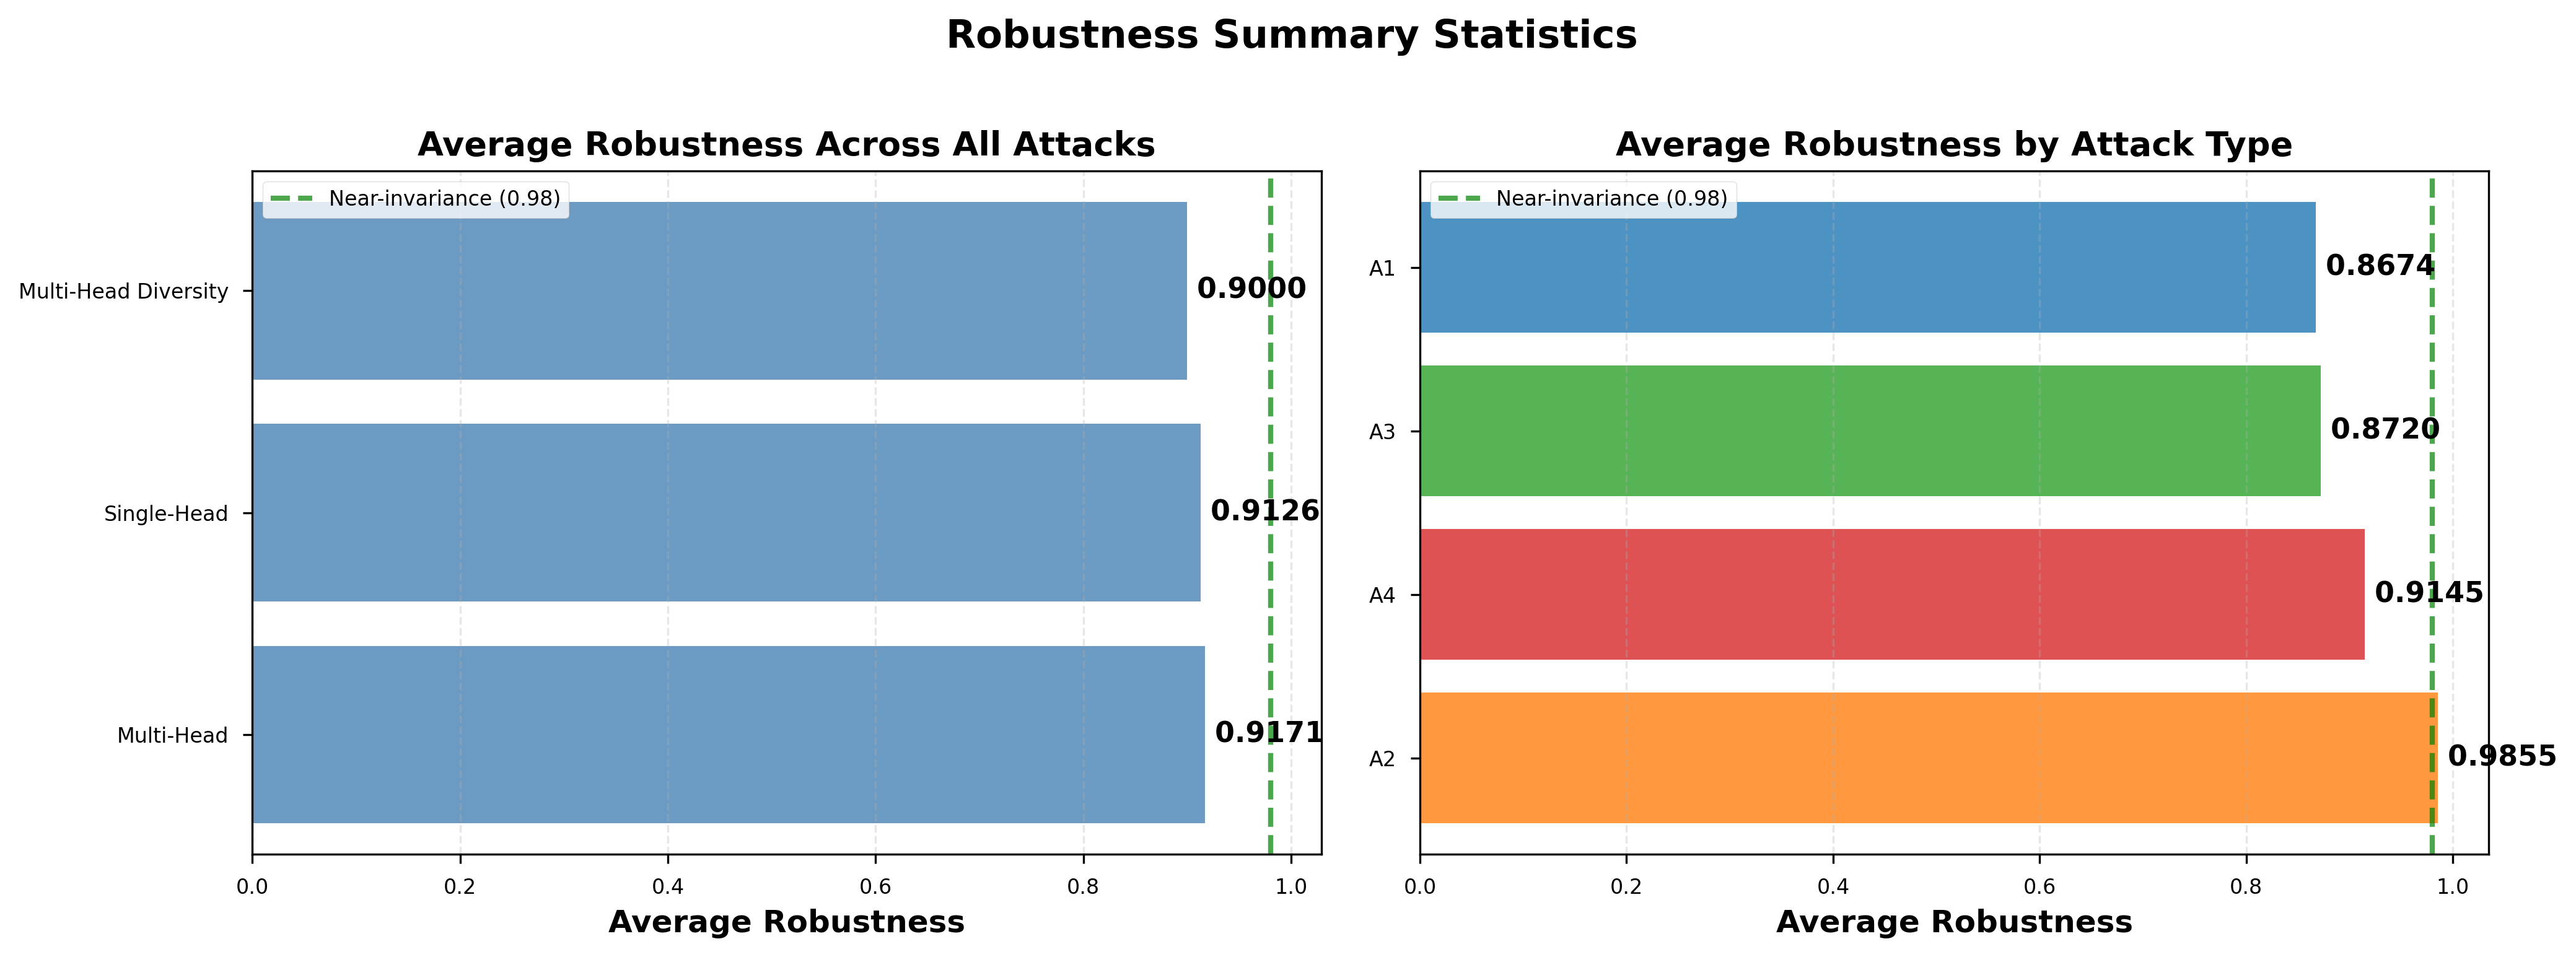

 All robustness visualizations complete!

Generated 6 comprehensive plots:
  1. Robustness Bar Charts by Attack Type (4 panels)
  2. Robustness vs Epsilon Line Plot
  3. Robustness Heatmaps (3 models)
  4. Delta RMSE Degradation Analysis (4 panels)
  5. Standard vs Adversarial Comparison (3 models)
  6. Summary Statistics (2 panels)


In [32]:
# Comprehensive Robustness Visualization
if 'robustness_results' in locals() and 'robustness_df' in locals() and len(robustness_results) > 0:
    # Filter to transformer models and training epsilons
    plot_data = robustness_df[
        (robustness_df['model_name'].isin(['Single-Head', 'Multi-Head', 'Multi-Head Diversity'])) &
        (robustness_df['epsilon'].isin(ATTACK_EPSILONS))
    ].copy()
    
    if len(plot_data) > 0:
        print("=" * 80)
        print("GENERATING COMPREHENSIVE ROBUSTNESS VISUALIZATIONS")
        print("=" * 80)
        
        # ============================================================
        # Plot 1: Robustness Bar Charts by Attack Type
        # ============================================================
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, attack_type in enumerate(ATTACK_TYPES):
            ax = axes[idx]
            attack_data = plot_data[plot_data['attack_type'] == attack_type]
            
            if len(attack_data) > 0:
                # Group by model and epsilon
                pivot_data = attack_data.pivot_table(
                    index='model_name', 
                    columns='epsilon', 
                    values='robustness', 
                    aggfunc='mean'
                )
                
                # Plot
                x_pos = np.arange(len(pivot_data.index))
                width = 0.25
                epsilons = sorted(attack_data['epsilon'].unique())
                colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
                
                for i, eps in enumerate(epsilons):
                    if eps in pivot_data.columns:
                        bars = ax.bar(x_pos + i*width, pivot_data[eps], width, 
                                     label=f'ε={eps}', alpha=0.8, color=colors[i % len(colors)])
                        # Add value labels on bars
                        for j, (bar, val) in enumerate(zip(bars, pivot_data[eps])):
                            height = bar.get_height()
                            ax.text(bar.get_x() + bar.get_width()/2., height,
                                   f'{val:.3f}', ha='center', va='bottom', fontsize=8)
                
                ax.set_xlabel('Model', fontsize=12)
                ax.set_ylabel('Robustness', fontsize=12)
                ax.set_title(f'{attack_type.upper()} Attack: Robustness by Model', fontsize=14, fontweight='bold')
                ax.set_xticks(x_pos + width)
                ax.set_xticklabels(pivot_data.index, rotation=45, ha='right')
                ax.legend(title='Epsilon', fontsize=10)
                ax.grid(True, alpha=0.3, axis='y', linestyle='--')
                ax.axhline(y=0.98, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Near-invariance (0.98)')
                ax.set_ylim([0.85, 1.01])
        
        plt.suptitle('Robustness Scores by Attack Type and Epsilon', fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
        
        # ============================================================
        # Plot 2: Robustness vs Epsilon (Line Plot)
        # ============================================================
        fig, ax = plt.subplots(1, 1, figsize=(14, 7))
        
        model_colors = {'Single-Head': '#1f77b4', 'Multi-Head': '#ff7f0e', 'Multi-Head Diversity': '#2ca02c'}
        attack_markers = {'a1': 'o', 'a2': 's', 'a3': '^', 'a4': 'D'}
        attack_labels = {'a1': 'A1 (Measurement Error)', 'a2': 'A2 (Missingness)', 
                        'a3': 'A3 (Rank Manipulation)', 'a4': 'A4 (Regime Shift)'}
        
        for model_name in ['Single-Head', 'Multi-Head', 'Multi-Head Diversity']:
            model_data = plot_data[plot_data['model_name'] == model_name]
            if len(model_data) > 0:
                avg_robustness = model_data.groupby(['attack_type', 'epsilon'])['robustness'].mean().reset_index()
                
                for attack_type in ATTACK_TYPES:
                    attack_data = avg_robustness[avg_robustness['attack_type'] == attack_type]
                    if len(attack_data) > 0:
                        ax.plot(attack_data['epsilon'], attack_data['robustness'], 
                               marker=attack_markers[attack_type], 
                               label=f'{model_name} - {attack_labels[attack_type]}', 
                               linewidth=2.5, markersize=10, alpha=0.8,
                               color=model_colors[model_name])
        
        ax.set_xlabel('Epsilon (Attack Strength)', fontsize=13, fontweight='bold')
        ax.set_ylabel('Robustness Score', fontsize=13, fontweight='bold')
        ax.set_title('Robustness vs Epsilon: All Models and Attacks', fontsize=15, fontweight='bold')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, framealpha=0.9)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.axhline(y=0.98, color='green', linestyle='--', linewidth=2, alpha=0.7, 
                  label='Near-invariance threshold (0.98)')
        ax.set_ylim([0.85, 1.01])
        ax.set_xlim([0.2, 1.05])
        plt.tight_layout()
        plt.show()
        
        # ============================================================
        # Plot 3: Robustness Heatmap
        # ============================================================
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for idx, model_name in enumerate(['Single-Head', 'Multi-Head', 'Multi-Head Diversity']):
            ax = axes[idx]
            model_data = plot_data[plot_data['model_name'] == model_name]
            
            if len(model_data) > 0:
                # Create pivot table for heatmap
                heatmap_data = model_data.pivot_table(
                    index='attack_type',
                    columns='epsilon',
                    values='robustness',
                    aggfunc='mean'
                )
                
                # Create heatmap
                im = ax.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', 
                              vmin=0.85, vmax=1.0, interpolation='nearest')
                
                # Set ticks and labels
                ax.set_xticks(np.arange(len(heatmap_data.columns)))
                ax.set_yticks(np.arange(len(heatmap_data.index)))
                ax.set_xticklabels([f'ε={eps}' for eps in heatmap_data.columns])
                ax.set_yticklabels([at.upper() for at in heatmap_data.index])
                
                # Add text annotations
                for i in range(len(heatmap_data.index)):
                    for j in range(len(heatmap_data.columns)):
                        text = ax.text(j, i, f'{heatmap_data.iloc[i, j]:.3f}',
                                     ha="center", va="center", color="black", fontweight='bold', fontsize=10)
                
                ax.set_title(f'{model_name}\nRobustness Heatmap', fontsize=12, fontweight='bold')
                ax.set_xlabel('Epsilon', fontsize=11)
                ax.set_ylabel('Attack Type', fontsize=11)
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=axes, orientation='horizontal', pad=0.1, aspect=40)
        cbar.set_label('Robustness Score', fontsize=12, fontweight='bold')
        plt.suptitle('Robustness Heatmaps: All Models', fontsize=15, fontweight='bold', y=1.05)
        plt.tight_layout()
        plt.show()
        
        # ============================================================
        # Plot 4: Delta RMSE (Degradation) Analysis
        # ============================================================
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, attack_type in enumerate(ATTACK_TYPES):
            ax = axes[idx]
            attack_data = plot_data[plot_data['attack_type'] == attack_type]
            
            if len(attack_data) > 0:
                # Group by model and epsilon
                pivot_delta = attack_data.pivot_table(
                    index='model_name',
                    columns='epsilon',
                    values='delta_rmse',
                    aggfunc='mean'
                )
                
                x_pos = np.arange(len(pivot_delta.index))
                width = 0.25
                epsilons = sorted(attack_data['epsilon'].unique())
                
                for i, eps in enumerate(epsilons):
                    if eps in pivot_delta.columns:
                        bars = ax.bar(x_pos + i*width, pivot_delta[eps] * 1000, width,
                                     label=f'ε={eps}', alpha=0.8)
                        # Add value labels
                        for j, (bar, val) in enumerate(zip(bars, pivot_delta[eps] * 1000)):
                            height = bar.get_height()
                            ax.text(bar.get_x() + bar.get_width()/2., height,
                                   f'{val:.2f}', ha='center', va='bottom' if height >= 0 else 'top', 
                                   fontsize=8)
                
                ax.set_xlabel('Model', fontsize=12)
                ax.set_ylabel('ΔRMSE (×1000)', fontsize=12)
                ax.set_title(f'{attack_type.upper()} Attack: RMSE Degradation', fontsize=14, fontweight='bold')
                ax.set_xticks(x_pos + width)
                ax.set_xticklabels(pivot_delta.index, rotation=45, ha='right')
                ax.legend(title='Epsilon', fontsize=10)
                ax.grid(True, alpha=0.3, axis='y', linestyle='--')
                ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        
        plt.suptitle('RMSE Degradation Under Attacks (Lower is Better)', fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
        
        # ============================================================
        # Plot 5: Standard vs Adversarially Trained Comparison
        # ============================================================
        if len(adversarial_models) > 0:
            # Separate standard and adversarial results
            standard_results = plot_data[plot_data['model_name'].isin(['Single-Head', 'Multi-Head', 'Multi-Head Diversity'])]
            adv_results = robustness_df[
                (~robustness_df['model_name'].isin(['OLS', 'Ridge', 'XGBoost', 'MLP', 'Single-Head', 'Multi-Head', 'Multi-Head Diversity'])) &
                (robustness_df['epsilon'].isin(ATTACK_EPSILONS))
            ].copy()
            
            if len(adv_results) > 0:
                adv_results['base_model'] = adv_results['model_name'].str.split('(').str[0].str.strip()
                
                fig, axes = plt.subplots(1, 3, figsize=(18, 5))
                
                for idx, base_model in enumerate(['Single-Head', 'Multi-Head', 'Multi-Head Diversity']):
                    ax = axes[idx]
                    
                    std_data = standard_results[standard_results['model_name'] == base_model]
                    adv_data = adv_results[adv_results['base_model'] == base_model]
                    
                    if len(std_data) > 0 and len(adv_data) > 0:
                        # Average robustness by attack type
                        std_avg = std_data.groupby('attack_type')['robustness'].mean()
                        adv_avg = adv_data.groupby('attack_type')['robustness'].mean()
                        
                        x = np.arange(len(ATTACK_TYPES))
                        width = 0.35
                        
                        bars1 = ax.bar(x - width/2, [std_avg.get(at, 0) for at in ATTACK_TYPES], 
                                      width, label='Standard Training', alpha=0.8, color='#1f77b4')
                        bars2 = ax.bar(x + width/2, [adv_avg.get(at, 0) for at in ATTACK_TYPES], 
                                      width, label='Adversarial Training', alpha=0.8, color='#ff7f0e')
                        
                        # Add value labels
                        for bars in [bars1, bars2]:
                            for bar in bars:
                                height = bar.get_height()
                                ax.text(bar.get_x() + bar.get_width()/2., height,
                                       f'{height:.3f}', ha='center', va='bottom', fontsize=9)
                        
                        ax.set_xlabel('Attack Type', fontsize=12)
                        ax.set_ylabel('Average Robustness', fontsize=12)
                        ax.set_title(f'{base_model}\nStandard vs Adversarial', fontsize=13, fontweight='bold')
                        ax.set_xticks(x)
                        ax.set_xticklabels([at.upper() for at in ATTACK_TYPES])
                        ax.legend(fontsize=10)
                        ax.grid(True, alpha=0.3, axis='y', linestyle='--')
                        ax.axhline(y=0.98, color='green', linestyle='--', linewidth=2, alpha=0.7)
                        ax.set_ylim([0.85, 1.01])
                
                plt.suptitle('Standard vs Adversarially Trained: Robustness Comparison', 
                            fontsize=15, fontweight='bold', y=1.02)
                plt.tight_layout()
                plt.show()
        
        # ============================================================
        # Plot 6: Summary Statistics
        # ============================================================
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Left: Average robustness by model
        ax = axes[0]
        model_avg_robustness = plot_data.groupby('model_name')['robustness'].mean().sort_values(ascending=False)
        bars = ax.barh(model_avg_robustness.index, model_avg_robustness.values, alpha=0.8, color='steelblue')
        for i, (bar, val) in enumerate(zip(bars, model_avg_robustness.values)):
            ax.text(val, i, f' {val:.4f}', va='center', fontsize=11, fontweight='bold')
        ax.set_xlabel('Average Robustness', fontsize=12, fontweight='bold')
        ax.set_title('Average Robustness Across All Attacks', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x', linestyle='--')
        ax.axvline(x=0.98, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Near-invariance (0.98)')
        ax.legend()
        
        # Right: Robustness by attack type
        ax = axes[1]
        attack_avg_robustness = plot_data.groupby('attack_type')['robustness'].mean().sort_values(ascending=False)
        colors_map = {'a1': '#1f77b4', 'a2': '#ff7f0e', 'a3': '#2ca02c', 'a4': '#d62728'}
        bars = ax.barh([at.upper() for at in attack_avg_robustness.index], 
                      attack_avg_robustness.values, 
                      alpha=0.8, 
                      color=[colors_map[at] for at in attack_avg_robustness.index])
        for i, (bar, val) in enumerate(zip(bars, attack_avg_robustness.values)):
            ax.text(val, i, f' {val:.4f}', va='center', fontsize=11, fontweight='bold')
        ax.set_xlabel('Average Robustness', fontsize=12, fontweight='bold')
        ax.set_title('Average Robustness by Attack Type', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x', linestyle='--')
        ax.axvline(x=0.98, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Near-invariance (0.98)')
        ax.legend()
        
        plt.suptitle('Robustness Summary Statistics', fontsize=15, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        print("=" * 80)
        print(" All robustness visualizations complete!")
        print("=" * 80)
        print(f"\nGenerated {6} comprehensive plots:")
        print("  1. Robustness Bar Charts by Attack Type (4 panels)")
        print("  2. Robustness vs Epsilon Line Plot")
        print("  3. Robustness Heatmaps (3 models)")
        print("  4. Delta RMSE Degradation Analysis (4 panels)")
        print("  5. Standard vs Adversarial Comparison (3 models)")
        print("  6. Summary Statistics (2 panels)")
    else:
        print("No data available for visualization. Run robustness evaluation first.")
else:
    print("No robustness results available. Run the 'Evaluate Models Under Adversarial Attacks' cell first.")

Making predictions on validation set...
OLS:
  RMSE: 0.017520
  R²: -0.007658

Ridge:
  RMSE: 0.017519
  R²: -0.007585

MLP:
  RMSE: 0.019840
  R²: -0.292290

Single-Head:
  RMSE: 0.016555
  R²: 0.100279

Multi-Head:
  RMSE: 0.016388
  R²: 0.118330

Multi-Head Diversity:
  RMSE: 0.016533
  R²: 0.102619

MODEL COMPARISON SUMMARY
               Model     RMSE        R²
          Multi-Head 0.016388  0.118330
Multi-Head Diversity 0.016533  0.102619
         Single-Head 0.016555  0.100279
               Ridge 0.017519 -0.007585
                 OLS 0.017520 -0.007658
                 MLP 0.019840 -0.292290


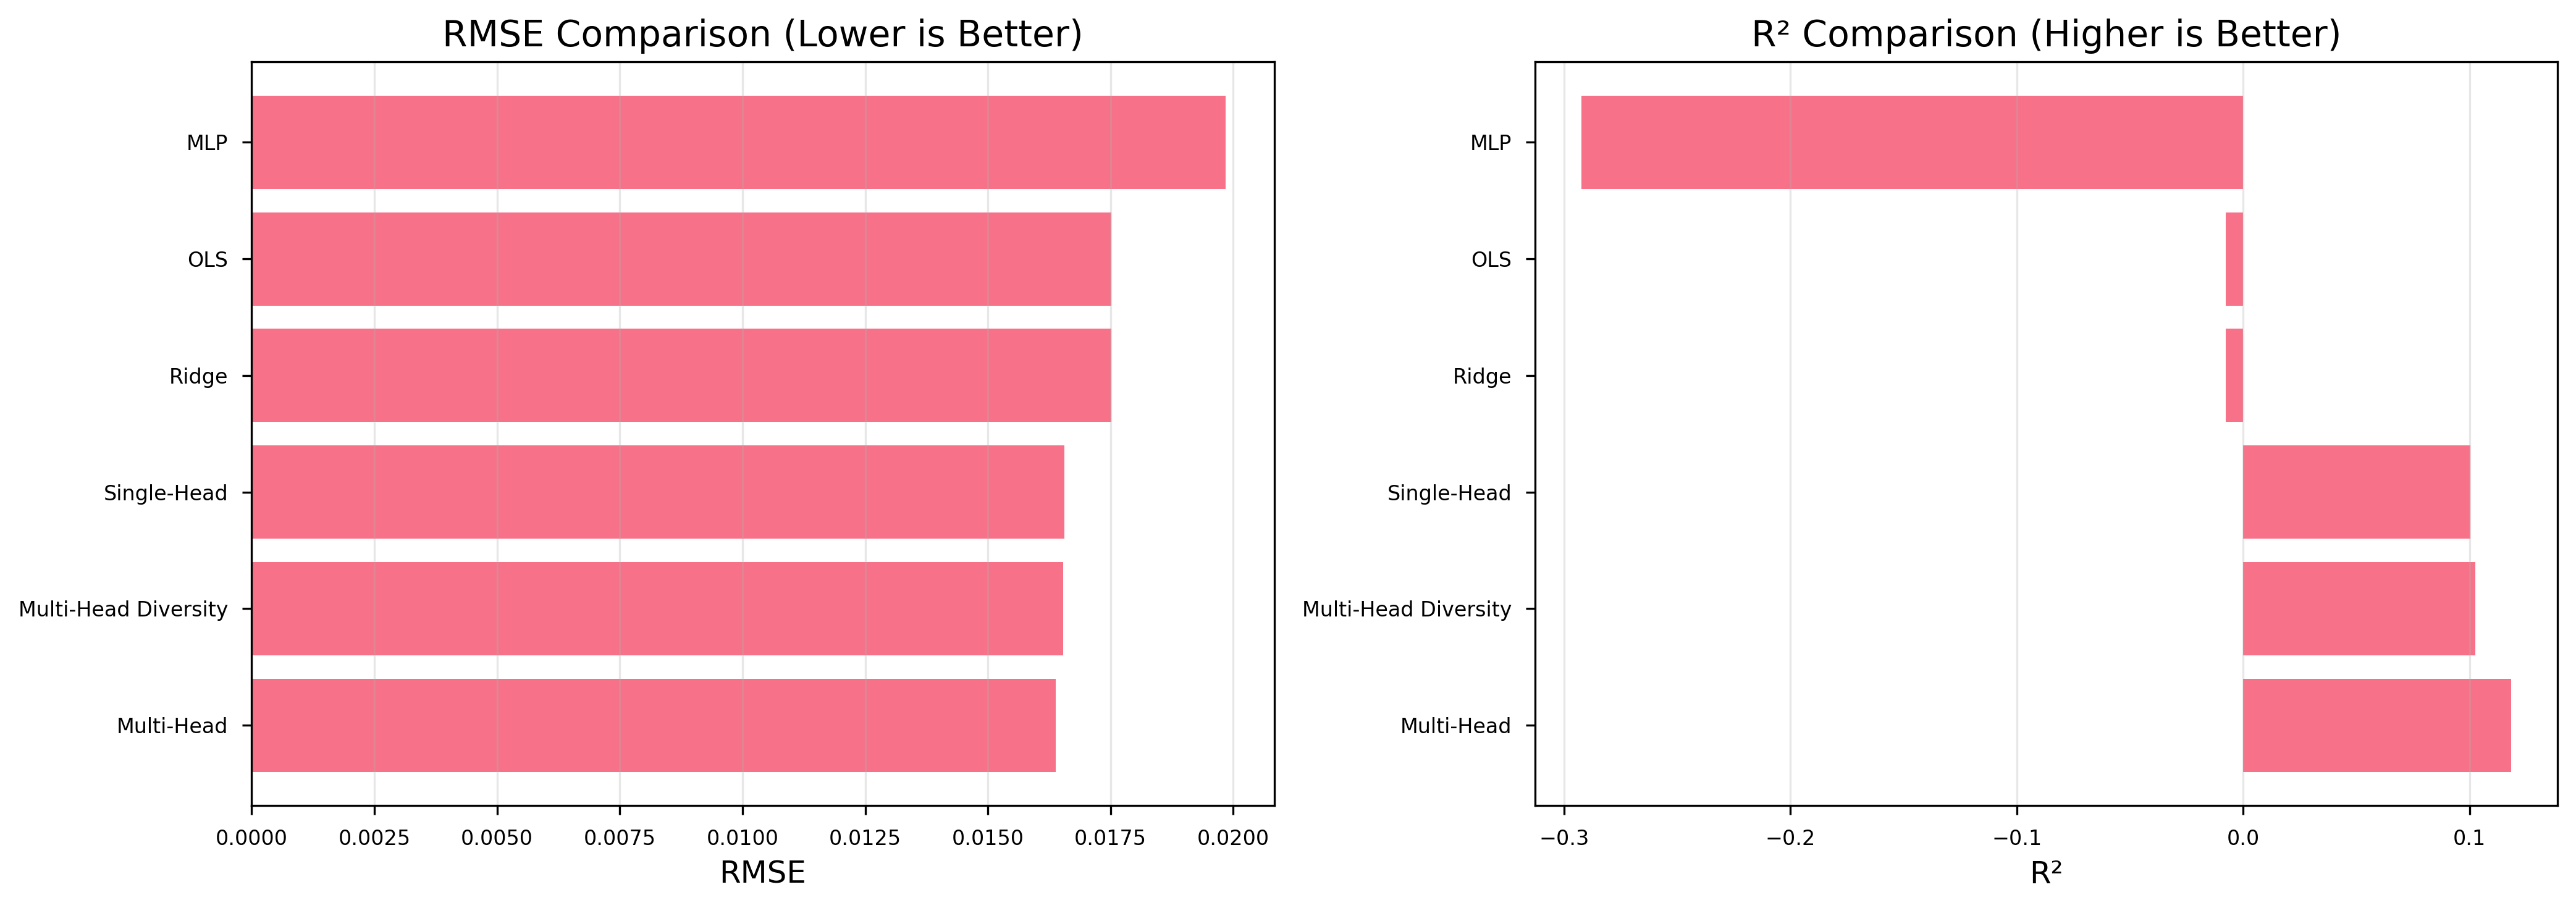

In [33]:
def make_predictions(model, X, device='cpu', batch_size=128, is_sklearn=False):
    """Make predictions with a model (deterministic mode)."""
    if is_sklearn:
        # sklearn models
        return model.predict(X)
    
    # PyTorch models
    model.eval()
    
    # Ensure deterministic mode - disable dropout
    with torch.no_grad():
        for module in model.modules():
            if isinstance(module, nn.Dropout):
                module.eval()
        
        predictions = []
        
        # Get num_features - handle both FeatureTokenTransformer and SingleHeadTransformer
        if hasattr(model, 'num_features'):
            num_features = model.num_features
        elif hasattr(model, 'model') and hasattr(model.model, 'num_features'):
            # SingleHeadTransformer wraps FeatureTokenTransformer in self.model
            num_features = model.model.num_features
        else:
            # Fallback: use input dimension
            num_features = X.shape[1]
        
        for i in range(0, len(X), batch_size):
            batch = X[i:i+batch_size]
            X_tensor = torch.FloatTensor(batch).to(device)
            
            # Handle padding if needed
            if X_tensor.shape[1] != num_features:
                if X_tensor.shape[1] < num_features:
                    padding = torch.zeros(X_tensor.shape[0], num_features - X_tensor.shape[1]).to(device)
                    X_tensor = torch.cat([X_tensor, padding], dim=1)
                else:
                    X_tensor = X_tensor[:, :num_features]
            
            pred = model(X_tensor)
            if isinstance(pred, tuple):
                pred = pred[0]
            predictions.append(pred.cpu().numpy())
    
    return np.concatenate(predictions, axis=0).flatten()

# Make predictions on validation set
print("Making predictions on validation set...")
predictions = {}

for name, model in models.items():
    is_sklearn = name in ['OLS', 'Ridge', 'XGBoost']
    pred = make_predictions(model, X_val_scaled, device, is_sklearn=is_sklearn)
    predictions[name] = pred.flatten()
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    r2 = r2_score(y_val, pred)
    
    print(f"{name}:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  R²: {r2:.6f}")
    print()
comparison_data = []
for name in ['OLS', 'Ridge', 'XGBoost', 'MLP', 'Single-Head', 'Multi-Head', 'Multi-Head Diversity']:
    if name in training_history:
        comparison_data.append({
            'Model': name,
            'RMSE': training_history[name]['rmse'],
            'R²': training_history[name]['r2']
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('R²', ascending=False)

print("=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
ax1.barh(comparison_df['Model'], comparison_df['RMSE'])
ax1.set_xlabel('RMSE', fontsize=12)
ax1.set_title('RMSE Comparison (Lower is Better)', fontsize=14)
ax1.grid(True, alpha=0.3, axis='x')

# R² comparison
ax2.barh(comparison_df['Model'], comparison_df['R²'])
ax2.set_xlabel('R²', fontsize=12)
ax2.set_title('R² Comparison (Higher is Better)', fontsize=14)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 5.1. Save Results 

This is a fixed version that handles missing variables gracefully.

In [34]:
# FIXED: Save all results to disk (handles missing variables)
import json
from datetime import datetime
import pickle

# Create output directory
output_dir = repo_root / 'notebooks' / 'saved_results'
output_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_prefix = output_dir / f'results_{timestamp}'

print("=" * 80)
print("SAVING ALL RESULTS (FIXED VERSION)")
print("=" * 80)
print(f"Output directory: {output_dir}")
print(f"Save prefix: {save_prefix}")
print()

# Initialize variables to track what was saved
robustness_path_saved = None
predictions_path_saved = None

# 1. Save standard models
print("1. Saving standard models...")
models_dir = save_prefix / 'models'
models_dir.mkdir(parents=True, exist_ok=True)

if 'models' in locals():
    for name, model in models.items():
        if name in ['OLS', 'Ridge', 'XGBoost']:
            # Save sklearn models
            model_path = models_dir / f'{name.lower()}_model.pkl'
            with open(model_path, 'wb') as f:
                pickle.dump(model, f)
            print(f"  ✓ Saved {name} to {model_path}")
        else:
            # Save PyTorch models
            model_path = models_dir / f'{name.lower().replace(" ", "_")}_model.pt'
            torch.save({
                'model_state_dict': model.state_dict(),
                'model_name': name,
                'timestamp': timestamp
            }, model_path)
            print(f"  ✓ Saved {name} to {model_path}")
else:
    print("  ⚠ No models to save")

# 2. Save adversarially trained models
print("\n2. Saving adversarially trained models...")
if 'adversarial_models' in locals() and len(adversarial_models) > 0:
    adv_models_dir = models_dir / 'adversarial'
    adv_models_dir.mkdir(parents=True, exist_ok=True)
    
    for model_key, adv_model in adversarial_models.items():
        safe_name = model_key.replace(' ', '_').replace('(', '').replace(')', '').replace('ε=', 'eps').replace(',', '_')
        model_path = adv_models_dir / f'{safe_name}_model.pt'
        torch.save({
            'model_state_dict': adv_model.state_dict(),
            'model_name': model_key,
            'timestamp': timestamp
        }, model_path)
        print(f"  ✓ Saved {model_key} to {model_path}")
else:
    print("  ⚠ No adversarially trained models to save")

# 3. Save training history
print("\n3. Saving training history...")
if 'training_history' in locals() and len(training_history) > 0:
    training_history_path = save_prefix / 'training_history.json'
    training_history_json = {}
    for name, metrics in training_history.items():
        training_history_json[name] = {}
        for key, value in metrics.items():
            if isinstance(value, (np.ndarray, list)):
                training_history_json[name][key] = [float(v) if isinstance(v, (np.floating, np.integer)) else v for v in value]
            elif isinstance(value, (np.floating, np.integer)):
                training_history_json[name][key] = float(value)
            else:
                training_history_json[name][key] = value
    
    with open(training_history_path, 'w') as f:
        json.dump(training_history_json, f, indent=2)
    print(f"  ✓ Saved training history to {training_history_path}")
else:
    print("  ⚠ No training history to save")
    training_history_path = save_prefix / 'training_history.json'

# 4. Save adversarial training history
print("\n4. Saving adversarial training history...")
if 'adversarial_training_history' in locals() and len(adversarial_training_history) > 0:
    adv_history_path = save_prefix / 'adversarial_training_history.json'
    adv_history_json = {}
    for name, metrics in adversarial_training_history.items():
        adv_history_json[name] = {
            'rmse': float(metrics['rmse']),
            'r2': float(metrics['r2']),
            'history': {
                'train_loss': [float(v) for v in metrics['history']['train_loss']],
                'val_loss': [float(v) for v in metrics['history']['val_loss']],
                'train_clean_loss': [float(v) for v in metrics['history']['train_clean_loss']],
                'train_adv_loss': [float(v) for v in metrics['history']['train_adv_loss']]
            }
        }
    
    with open(adv_history_path, 'w') as f:
        json.dump(adv_history_json, f, indent=2)
    print(f"  ✓ Saved adversarial training history to {adv_history_path}")
else:
    print("  ⚠ No adversarial training history to save")
    adv_history_path = save_prefix / 'adversarial_training_history.json'

# 5. Save robustness results (FIXED: Check if variables exist)
print("\n5. Saving robustness results...")
if 'robustness_results' in locals() and 'robustness_df' in locals() and len(robustness_results) > 0:
    robustness_path = save_prefix / 'robustness_results.csv'
    robustness_df.to_csv(robustness_path, index=False)
    print(f"  ✓ Saved robustness results to {robustness_path}")
    
    # Also save as JSON
    robustness_json_path = save_prefix / 'robustness_results.json'
    robustness_json = robustness_df.to_dict('records')
    for record in robustness_json:
        for key, value in record.items():
            if isinstance(value, (np.floating, np.integer)):
                record[key] = float(value)
    with open(robustness_json_path, 'w') as f:
        json.dump(robustness_json, f, indent=2)
    print(f"  ✓ Saved robustness results (JSON) to {robustness_json_path}")
    robustness_path_saved = str(robustness_path)
else:
    print("  ⚠ No robustness results to save (run robustness evaluation first)")
    robustness_path_saved = None

# 6. Save predictions (FIXED: Check if variable exists)
print("\n6. Saving predictions...")
if 'predictions' in locals() and len(predictions) > 0:
    predictions_path = save_prefix / 'predictions.json'
    predictions_json = {}
    for name, pred in predictions.items():
        predictions_json[name] = {
            'predictions': pred.tolist() if isinstance(pred, np.ndarray) else pred,
            'actual': y_val.tolist() if isinstance(y_val, np.ndarray) else y_val.tolist()
        }
    with open(predictions_path, 'w') as f:
        json.dump(predictions_json, f, indent=2)
    print(f"  ✓ Saved predictions to {predictions_path}")
    predictions_path_saved = str(predictions_path)
else:
    print("  ⚠ No predictions to save (run prediction cells first)")
    predictions_path = save_prefix / 'predictions.json'
    predictions_path_saved = None

# 7. Save data info
print("\n7. Saving data information...")
if 'splitter' in locals() and 'X_train_scaled' in locals():
    data_info = {
        'train_period': f"{splitter.train_start} to {splitter.train_end}",
        'val_period': f"{splitter.val_start} to {splitter.val_end}",
        'train_samples': len(X_train_scaled),
        'val_samples': len(X_val_scaled),
        'num_features': X_train_scaled.shape[1],
        'target_column': y_train.name if hasattr(y_train, 'name') else 'returns_1d',
        'random_seed': RANDOM_SEED,
        'timestamp': timestamp
    }
    data_info_path = save_prefix / 'data_info.json'
    with open(data_info_path, 'w') as f:
        json.dump(data_info, f, indent=2)
    print(f"  ✓ Saved data info to {data_info_path}")
else:
    print("  ⚠ No data info to save")
    data_info_path = save_prefix / 'data_info.json'

# 8. Create summary file (FIXED: Handle missing variables)
print("\n8. Creating summary file...")
summary = {
    'timestamp': timestamp,
    'models_trained': list(models.keys()) if 'models' in locals() else [],
    'adversarial_models_trained': len(adversarial_models) if 'adversarial_models' in locals() else 0,
    'robustness_evaluations': len(robustness_results) if 'robustness_results' in locals() else 0,
    'training_history_models': list(training_history.keys()) if 'training_history' in locals() else [],
    'adversarial_training_history_models': list(adversarial_training_history.keys()) if 'adversarial_training_history' in locals() else [],
    'files_saved': {
        'models_dir': str(models_dir),
        'training_history': str(training_history_path),
        'robustness_results': robustness_path_saved,
        'predictions': predictions_path_saved,
        'data_info': str(data_info_path)
    }
}
summary_path = save_prefix / 'summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"  ✓ Saved summary to {summary_path}")

print("\n" + "=" * 80)
print("SAVE COMPLETE")
print("=" * 80)
print(f"\nAll results saved to: {save_prefix}")
print(f"\nTo load results later, use the 'Load Saved Results' cell below.")

SAVING ALL RESULTS (FIXED VERSION)
Output directory: /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results
Save prefix: /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081906

1. Saving standard models...


  ✓ Saved OLS to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081906/models/ols_model.pkl
  ✓ Saved Ridge to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081906/models/ridge_model.pkl
  ✓ Saved MLP to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081906/models/mlp_model.pt
  ✓ Saved Single-Head to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081906/models/single-head_model.pt
  ✓ Saved Multi-Head to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081906/models/multi-head_model.pt
  ✓ Saved Multi-Head Diversity to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081906/models/multi-head_diversity_model.pt

2. Saving adversarially trained models...
  ✓ Saved Single-Head (A1, ε=0.25) to /content/drive/

  ✓ Saved Multi-Head (A4, ε=0.5) to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081906/models/adversarial/Multi-Head_A4__eps0.5_model.pt
  ✓ Saved Multi-Head (A4, ε=1.0) to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081906/models/adversarial/Multi-Head_A4__eps1.0_model.pt
  ✓ Saved Multi-Head Diversity (A1, ε=0.25) to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081906/models/adversarial/Multi-Head_Diversity_A1__eps0.25_model.pt
  ✓ Saved Multi-Head Diversity (A1, ε=0.5) to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081906/models/adversarial/Multi-Head_Diversity_A1__eps0.5_model.pt
  ✓ Saved Multi-Head Diversity (A1, ε=1.0) to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081906/models/adversarial/Multi-Head_Diversity_A1__eps1.0_model.p

uded

In [35]:
# Save all results to disk
import json
from datetime import datetime
import pickle

# Create output directory
output_dir = repo_root / 'notebooks' / 'saved_results'
output_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_prefix = output_dir / f'results_{timestamp}'

print("=" * 80)
print("SAVING ALL RESULTS")
print("=" * 80)
print(f"Output directory: {output_dir}")
print(f"Save prefix: {save_prefix}")
print()

# 1. Save standard models
print("1. Saving standard models...")
models_dir = save_prefix / 'models'
models_dir.mkdir(parents=True, exist_ok=True)

for name, model in models.items():
    if name in ['OLS', 'Ridge', 'XGBoost']:
        # Save sklearn models
        model_path = models_dir / f'{name.lower()}_model.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"  ✓ Saved {name} to {model_path}")
    else:
        # Save PyTorch models
        model_path = models_dir / f'{name.lower().replace(" ", "_")}_model.pt'
        torch.save({
            'model_state_dict': model.state_dict(),
            'model_name': name,
            'timestamp': timestamp
        }, model_path)
        print(f"  ✓ Saved {name} to {model_path}")

# 2. Save adversarially trained models
print("\n2. Saving adversarially trained models...")
adv_models_dir = models_dir / 'adversarial'
adv_models_dir.mkdir(parents=True, exist_ok=True)

for model_key, adv_model in adversarial_models.items():
    safe_name = model_key.replace(' ', '_').replace('(', '').replace(')', '').replace('ε=', 'eps').replace(',', '_')
    model_path = adv_models_dir / f'{safe_name}_model.pt'
    torch.save({
        'model_state_dict': adv_model.state_dict(),
        'model_name': model_key,
        'timestamp': timestamp
    }, model_path)
    print(f"  ✓ Saved {model_key} to {model_path}")

# 3. Save training history
print("\n3. Saving training history...")
training_history_path = save_prefix / 'training_history.json'
# Convert numpy types to native Python types for JSON serialization
training_history_json = {}
for name, metrics in training_history.items():
    training_history_json[name] = {}
    for key, value in metrics.items():
        if isinstance(value, (np.ndarray, list)):
            training_history_json[name][key] = [float(v) if isinstance(v, (np.floating, np.integer)) else v for v in value]
        elif isinstance(value, (np.floating, np.integer)):
            training_history_json[name][key] = float(value)
        else:
            training_history_json[name][key] = value

with open(training_history_path, 'w') as f:
    json.dump(training_history_json, f, indent=2)
print(f" Saved training history to {training_history_path}")

# 4. Save adversarial training history
if adversarial_training_history:
    print("\n4. Saving adversarial training history...")
    adv_history_path = save_prefix / 'adversarial_training_history.json'
    adv_history_json = {}
    for name, metrics in adversarial_training_history.items():
        adv_history_json[name] = {
            'rmse': float(metrics['rmse']),
            'r2': float(metrics['r2']),
            'history': {
                'train_loss': [float(v) for v in metrics['history']['train_loss']],
                'val_loss': [float(v) for v in metrics['history']['val_loss']],
                'train_clean_loss': [float(v) for v in metrics['history']['train_clean_loss']],
                'train_adv_loss': [float(v) for v in metrics['history']['train_adv_loss']]
            }
        }
    
    with open(adv_history_path, 'w') as f:
        json.dump(adv_history_json, f, indent=2)
    print(f"  Saved adversarial training history to {adv_history_path}")

# 5. Save robustness results
print("\n5. Saving robustness results...")
if len(robustness_results) > 0:
    robustness_path = save_prefix / 'robustness_results.csv'
    robustness_df.to_csv(robustness_path, index=False)
    print(f"  Saved robustness results to {robustness_path}")
    
    # Also save as JSON for easier loading
    robustness_json_path = save_prefix / 'robustness_results.json'
    robustness_json = robustness_df.to_dict('records')
    # Convert numpy types
    for record in robustness_json:
        for key, value in record.items():
            if isinstance(value, (np.floating, np.integer)):
                record[key] = float(value)
    with open(robustness_json_path, 'w') as f:
        json.dump(robustness_json, f, indent=2)
    print(f"  Saved robustness results (JSON) to {robustness_json_path}")
else:
    print("  No robustness results to save")

# 6. Save predictions
print("\n6. Saving predictions...")
predictions_path = save_prefix / 'predictions.json'
predictions_json = {}
for name, pred in predictions.items():
    predictions_json[name] = {
        'predictions': pred.tolist() if isinstance(pred, np.ndarray) else pred,
        'actual': y_val.tolist() if isinstance(y_val, np.ndarray) else y_val.tolist()
    }
with open(predictions_path, 'w') as f:
    json.dump(predictions_json, f, indent=2)
print(f"  Saved predictions to {predictions_path}")

# 7. Save data info
print("\n7. Saving data information...")
data_info = {
    'train_period': f"{splitter.train_start} to {splitter.train_end}",
    'val_period': f"{splitter.val_start} to {splitter.val_end}",
    'train_samples': len(X_train_scaled),
    'val_samples': len(X_val_scaled),
    'num_features': X_train_scaled.shape[1],
    'target_column': y_train.name if hasattr(y_train, 'name') else 'returns_1d',
    'random_seed': RANDOM_SEED,
    'timestamp': timestamp
}
data_info_path = save_prefix / 'data_info.json'
with open(data_info_path, 'w') as f:
    json.dump(data_info, f, indent=2)
print(f"  Saved data info to {data_info_path}")

# 8. Create summary file
print("\n8. Creating summary file...")
summary = {
    'timestamp': timestamp,
    'models_trained': list(models.keys()),
    'adversarial_models_trained': len(adversarial_models),
    'robustness_evaluations': len(robustness_results),
    'training_history_models': list(training_history.keys()),
    'adversarial_training_history_models': list(adversarial_training_history.keys()),
    'files_saved': {
        'models_dir': str(models_dir),
        'training_history': str(training_history_path),
        'robustness_results': str(robustness_path) if len(robustness_results) > 0 else None,
        'predictions': str(predictions_path),
        'data_info': str(data_info_path)
    }
}
summary_path = save_prefix / 'summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"  Saved summary to {summary_path}")

print("\n" + "=" * 80)
print("SAVE COMPLETE")
print("=" * 80)
print(f"\nAll results saved to: {save_prefix}")
print(f"\nTo load results later, use the 'Load Saved Results' cell below.")

SAVING ALL RESULTS
Output directory: /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results
Save prefix: /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081907

1. Saving standard models...
  ✓ Saved OLS to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081907/models/ols_model.pkl
  ✓ Saved Ridge to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081907/models/ridge_model.pkl
  ✓ Saved MLP to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081907/models/mlp_model.pt
  ✓ Saved Single-Head to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081907/models/single-head_model.pt
  ✓ Saved Multi-Head to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081907/models/multi-head_model.pt
  ✓ Saved

  ✓ Saved Multi-Head (A4, ε=0.25) to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081907/models/adversarial/Multi-Head_A4__eps0.25_model.pt
  ✓ Saved Multi-Head (A4, ε=0.5) to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081907/models/adversarial/Multi-Head_A4__eps0.5_model.pt
  ✓ Saved Multi-Head (A4, ε=1.0) to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081907/models/adversarial/Multi-Head_A4__eps1.0_model.pt
  ✓ Saved Multi-Head Diversity (A1, ε=0.25) to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081907/models/adversarial/Multi-Head_Diversity_A1__eps0.25_model.pt
  ✓ Saved Multi-Head Diversity (A1, ε=0.5) to /content/drive/MyDrive/multihead-attention-robustness/notebooks/saved_results/results_20260123_081907/models/adversarial/Multi-Head_Diversity_A1__eps0.5_model.pt
  ✓ Saved Multi-

## 6. Load Saved Results


In [36]:
# Load saved results (optional - use this instead of training from scratch)
# Uncomment and modify the path to load a specific saved run

# Option 1: Load the most recent saved results
saved_results_dir = repo_root / 'notebooks' / 'saved_results'
if saved_results_dir.exists():
    saved_runs = sorted([d for d in saved_results_dir.iterdir() if d.is_dir()], 
                       key=lambda x: x.name, reverse=True)
    if saved_runs:
        latest_run = saved_runs[0]
        print(f"Found {len(saved_runs)} saved run(s). Latest: {latest_run.name}")
        print(f"\nTo load, uncomment the code below and set: load_path = latest_run")
        print(f"Or specify a specific run: load_path = saved_results_dir / 'results_YYYYMMDD_HHMMSS'")
    else:
        print("No saved runs found.")
else:
    print("Saved results directory does not exist. Run the 'Save Results' cell first.")

# Option 2: Load a specific saved run (uncomment and modify)
# load_path = saved_results_dir / 'results_20240101_120000'  # Replace with your timestamp

# Uncomment below to load:
"""
if 'load_path' in locals() and load_path.exists():
    print("=" * 80)
    print("LOADING SAVED RESULTS")
    print("=" * 80)
    print(f"Loading from: {load_path}")
    
    # Load summary
    summary_path = load_path / 'summary.json'
    if summary_path.exists():
        with open(summary_path, 'r') as f:
            loaded_summary = json.load(f)
        print(f"\nLoaded run from: {loaded_summary['timestamp']}")
        print(f"Models: {loaded_summary['models_trained']}")
    
    # Load models
    models_dir = load_path / 'models'
    if models_dir.exists():
        print("\nLoading standard models...")
        for model_file in models_dir.glob('*.pt'):
            # Skip adversarial models directory
            if model_file.parent.name == 'adversarial':
                continue
            # Load PyTorch model
            checkpoint = torch.load(model_file, map_location=device, weights_only=False)
            model_name = checkpoint.get('model_name', model_file.stem)
            print(f"  Loading {model_name}...")
            # Note: You'll need to recreate the model architecture first
            # This is a placeholder - actual loading depends on model type
        
        for model_file in models_dir.glob('*.pkl'):
            with open(model_file, 'rb') as f:
                model = pickle.load(f)
            model_name = model_file.stem.replace('_model', '').upper()
            models[model_name] = model
            print(f"  ✓ Loaded {model_name}")
    
    # Load robustness results
    robustness_path = load_path / 'robustness_results.csv'
    if robustness_path.exists():
        robustness_df = pd.read_csv(robustness_path)
        robustness_results = robustness_df.to_dict('records')
        print(f"\n✓ Loaded {len(robustness_results)} robustness results")
    
    # Load training history
    training_history_path = load_path / 'training_history.json'
    if training_history_path.exists():
        with open(training_history_path, 'r') as f:
            training_history = json.load(f)
        print(f"✓ Loaded training history for {len(training_history)} models")
    
    print("\n✓ Load complete!")
else:
    print("No load_path specified or path does not exist.")
"""

Found 11 saved run(s). Latest: results_20260123_081907

To load, uncomment the code below and set: load_path = latest_run
Or specify a specific run: load_path = saved_results_dir / 'results_YYYYMMDD_HHMMSS'


'\nif \'load_path\' in locals() and load_path.exists():\n    print("=" * 80)\n    print("LOADING SAVED RESULTS")\n    print("=" * 80)\n    print(f"Loading from: {load_path}")\n    \n    # Load summary\n    summary_path = load_path / \'summary.json\'\n    if summary_path.exists():\n        with open(summary_path, \'r\') as f:\n            loaded_summary = json.load(f)\n        print(f"\nLoaded run from: {loaded_summary[\'timestamp\']}")\n        print(f"Models: {loaded_summary[\'models_trained\']}")\n    \n    # Load models\n    models_dir = load_path / \'models\'\n    if models_dir.exists():\n        print("\nLoading standard models...")\n        for model_file in models_dir.glob(\'*.pt\'):\n            # Skip adversarial models directory\n            if model_file.parent.name == \'adversarial\':\n                continue\n            # Load PyTorch model\n            checkpoint = torch.load(model_file, map_location=device, weights_only=False)\n            model_name = checkpoint.get(\